# Mental Health in the Tech Industry

#### This analysis concerns a Mental Health Study from 2014-2019 for the global tech industry. The purpose of this exercise was to learn SQL and how to use it in Python (via SQLite3). It also aided in developing my plotting and storytelling skills as an analyst

In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sq3
import nltk
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from functions.remove_borders import remove_borders

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Table of Contents:
* Data Preparation
* Initial Analysis
* Exploratory Data Analysis
* Conclusions
* Improvement points

## Data Preparation

In [2]:
con = sq3.connect('mental_health.sqlite', detect_types= 1, )
cur = con.cursor()

First of all, let's check what the schema of the database is (e.g. what are the titles of the tables & the links between these tables):

In [3]:
tables = cur.execute('SELECT name FROM sqlite_schema').fetchall()
print(f"The tables names: {tables}")

The tables names: [('Answer',), ('Question',), ('Survey',)]


In [4]:
col_names = {}
for table in tables:
   column_attributes = cur.execute(f"PRAGMA table_info({table[0]})").fetchall()
   table_columns = [description[1] for description in column_attributes]
   col_names.update({table[0] : table_columns})
col_names

{'Answer': ['AnswerText', 'SurveyID', 'UserID', 'QuestionID'],
 'Question': ['questiontext', 'questionid'],
 'Survey': ['SurveyID', 'Description']}

Let's look at these tables and what's stored in them:

In [5]:
def execute_query(query: str, given_column_names : [str] = [], index : [str] = 0) -> pd.DataFrame:
    if index:
        results = pd.DataFrame(cur.execute(query).fetchall(), columns=given_column_names).set_index(index)
    else:
        results = pd.DataFrame(cur.execute(query).fetchall(), columns=given_column_names)
    return results

The `Answer` table:

In [6]:
query = """SELECT *
            FROM Answer
            LIMIT 5"""
execute_query(query, col_names['Answer'])

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


The `Question` table:

In [7]:
query = """SELECT *
            FROM Question
            LIMIT 5"""
execute_query(query, col_names['Question'], col_names['Question'][1])

,questiontext
questionid,
1,What is your age?
2,What is your gender?
3,What country do you live in?
4,"If you live in the United States, which state or territory do you live in?"
5,Are you self-employed?


The `Survey` table:

In [8]:
query = """SELECT *
            FROM Survey
            LIMIT 5"""
execute_query(query, col_names['Survey'], col_names['Survey'][0])

,Description
SurveyID,
2014,mental health survey for 2014
2016,mental health survey for 2016
2017,mental health survey for 2017
2018,mental health survey for 2018
2019,mental health survey for 2019


It looks as though the tables are connected in this particular way:

Connections:
* `SurveyID` (Primary Key in `Survey`) <===> `SurveyID` (Foreign Key in `Answer`)
* `QuestionID` (Primary Key in `Question`) <===> `QuestionID` (Foreign Key in `Answer`)

Alright, now that we have understoof the connections between tables, let's create a master table that would hold the same information in one information, since Question & Survey Id tables only hold 1 column each. 

In [9]:
query = """CREATE TEMPORARY TABLE master_table as 
                SELECT s.Description as Survey, q.questiontext as Question, a.UserID, a.AnswerText as Answer
            FROM Answer a
            FULL JOIN Question q
            on a.QuestionId = q.questionid
            FULL JOIN Survey s
            on a.SurveyID = s.SurveyID 
            ORDER BY 1, 2, 3
            """
# query = "DROP TABLE master_table"
cur.execute(query);

Now that we have set up a master table, let's dive into an initial analysis of the metadata of the dataset  

## Initial Analysis

In [10]:
query = "SELECT * FROM master_table LIMIT 10"
column_names = ['Survey', 'Question', 'UserID', 'Answer']
execute_query(query, column_names)

,Survey,Question,UserID,Answer
0,mental health survey for 2014,Any additional notes or comments,1,-1
1,mental health survey for 2014,Any additional notes or comments,2,-1
2,mental health survey for 2014,Any additional notes or comments,3,-1
3,mental health survey for 2014,Any additional notes or comments,4,-1
4,mental health survey for 2014,Any additional notes or comments,5,-1
5,mental health survey for 2014,Any additional notes or comments,6,-1
6,mental health survey for 2014,Any additional notes or comments,7,-1
7,mental health survey for 2014,Any additional notes or comments,8,-1
8,mental health survey for 2014,Any additional notes or comments,9,-1
9,mental health survey for 2014,Any additional notes or comments,10,-1


Even from this, we can already see that their are a lot of "-1" Answers to questions. This might be an indication that "-1" is the default metric for a value that is non-existent in this database (aka. NaN). But let's check how many of these "-1" answers do we have?

In [11]:
query = """ SELECT Survey,
                COUNT(UserID) AS nr_of_participants,
                SUM(questions_asked) AS total_nr_of_questions_asked,
                ROUND(SUM(questions_asked) / CAST(COUNT(UserID) AS FLOAT), 2) AS total_nr_of_questions_asked,
                SUM(count_non_responses),
                AVG(count_non_responses) as average_nr_of_non_responses, avg(perc_not_responded) as avg_perc_not_responded
            FROM
            (
                SELECT UserID, Survey,
                SUM(CASE WHEN Answer = -1 then 1 else 0 end) AS count_non_responses,
                SUM(CASE WHEN Answer = -1 then 1 else 0 end) / cast(count(Answer) as float) AS perc_not_responded,
                COUNT(Answer) AS questions_asked
                FROM master_table
                GROUP BY UserID, Survey
                --ORDER BY 4 desc
                ) o
            GROUP BY Survey"""
column_names = ['Survey', 'nr_of_participants', 'total_questions_asked', 'questions_per_participant',
                'total_nr_of_non_responses', 'average_nr_of_non_responses', 'avg_perc_not_responded']
index = ['Survey']
execute_query(query, column_names, index)

,nr_of_participants,total_questions_asked,questions_per_participant,total_nr_of_non_responses,average_nr_of_non_responses,avg_perc_not_responded
Survey,,,,,,
mental health survey for 2014,1260,32760,26.00,1898,1.506349,0.057937
mental health survey for 2016,1433,88238,61.58,20593,14.370551,0.233486
mental health survey for 2017,756,57456,76.00,16948,22.417989,0.294974
mental health survey for 2018,417,31692,76.00,9193,22.045564,0.290073
mental health survey for 2019,352,26752,76.00,7966,22.630682,0.297772


This is interesting. This means that each year there are at least 14 questions that people on average do not respond to (except in 2014, where there was only ~1.5 questions not given answers to). Percentage-wise, ~30% of all questions are not responded to each year (again, except for 2014). This means that either 2014 was an exceptional year for the survey, or for that year, there was another value used for identifying NaN values.

We also see that over the years, the number of participants have been steadily decreasing, although the number of total questions asked has shot up. This results in the average nr. of questions per participant being lower in 2014 & 2016, but higher ever since 2017. Maybe that is actually the reason, there is lower turnout for these surveys - people get scared off by the amount of questions in the Survey.


In [12]:
query = """ SELECT Survey, Answer, count(1)
            FROM master_table
            WHERE Survey = 'mental health survey for 2014'
            GROUP BY Survey, Answer
            ORDER BY 3 DESC
            LIMIT 10"""
column_names = ['Survey', 'Answer', 'Value_Counts']
index = ['Survey']
execute_query(query, column_names, index)

,Answer,Value_Counts
Survey,,
mental health survey for 2014,No,9079
mental health survey for 2014,Yes,4512
mental health survey for 2014,Don't know,2919
mental health survey for 2014,0,1948
mental health survey for 2014,-1,1898
mental health survey for 2014,1,1814
mental health survey for 2014,Maybe,1515
mental health survey for 2014,Some of them,1125
mental health survey for 2014,Male,991


There seem to be such values as `Don't know` & `Maybe` that are quite popular along with common Yes/No responses that indicate a boolean nature of questions. This will necessitate further standardization (which we will delve into deeper). Now what about the questions that have the most non-responses from the Survey years.


I assume that with regards to Binary questions, the value 1 = True, 0 = False, -1 = No Response (-1 is also seen for free-form questions)

In [13]:
query = """SELECT Question,
                SUM(CASE WHEN Answer = -1 then 1 else 0 end) as non_responses, count(Answer) AS total_questions,
            round(100.0 * SUM(CASE WHEN Answer = -1 then 1 else 0 end) / cast(count(Answer) as float), 3) AS perc_non_responses
            FROM master_table
            GROUP BY Question
            --HAVING SUM(CASE WHEN Answer = -1 then 1 else 0 end) / cast(count(Answer) as float) > 0.5
            ORDER BY 4 desc
            LIMIT 10
            """
column_names = ['Question', 'count_non_responses', 'times_question_shown', 'perc_incomplete']
index = ['Question']
execute_query(query, column_names, index)

,count_non_responses,times_question_shown,perc_incomplete
Question,,,
Describe the circumstances of the supportive or well handled response.,1525,1525,100.000
How has it affected your career?,1465,1525,96.066
"If you have revealed a mental health disorder to a client or business contact, how has this affected you or the relationship?",1433,1525,93.967
"If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?",1289,1433,89.951
Has being identified as a person with a mental health issue affected your career?,1345,1525,88.197
"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",2591,2958,87.593
Any additional notes or comments,1097,1260,87.063
"If you have revealed a mental health disorder to a coworker or employee, how has this impacted you or the relationship?",1308,1525,85.770
"Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",1297,1525,85.049


In this category we see a lot of free-text questions, which can explain why these questions were skipped as it can be labersome to fill out these long questions. We also see conditional questions, that would require the respondent to fit a certain condition for it to be answered - another potential reason for why they might be leading to multiple non-responses. What if we only checkd for other columns? 

In [14]:
query = """SELECT Question,
                SUM(CASE WHEN Answer = -1 then 1 else 0 end) as non_responses, count(Answer) AS total_questions,
            round(100.0 * SUM(CASE WHEN Answer = -1 then 1 else 0 end) / cast(count(Answer) as float), 3) AS perc_non_responses
            FROM master_table
            WHERE Question NOT LIKE "If you have%" AND Question NOT LIKE "Describe%" and Question NOT LIKE "If yes%"
            AND Question != 'Any additional notes or comments'
            GROUP BY Question
            ORDER BY 4 desc
            LIMIT 10
            """
column_names = ['Question', 'count_non_responses', 'times_question_shown', 'perc_incomplete']
index = ['Question']
data = execute_query(query, column_names, index)

Now we can see a much more improved distribution of the top questions by percentage of NA values within them (the % of total respondents that skipped the question when answering the survey). This is good, as we will not be analyzing free-form questions' answers and most conditional columns will be dealth with later. Now, since these surveys have been conducted on technology organizations, it would be interesting to understand what is the distribution of responses between non-tech and tech organizations. 

In [15]:
interesting_questions = ['How many employees does your company or organization have?',
                        'If you live in the United States, which state or territory do you live in?',
                        'What country do you live in?',
                        'Is your employer primarily a tech company/organization?',
                        'What is your gender?',
                        'What is your age?',
                        'What is your race?',
                        'Do you currently have a mental health disorder?'
                        ]

In [16]:
query = f"""SELECT Question, Answer, count(UserID) 
            FROM master_table
            where Question in ("{interesting_questions[0]}") and Answer != '-1'
            GROUP BY Question, Answer
            ORDER BY 1, 3 DESC"""
column_names = ['Question', 'Answer', 'Nr of Respondents']
index = ['Question']
execute_query(query, column_names, index)

,Answer,Nr of Respondents
Question,,
How many employees does your company or organization have?,More than 1000,912
How many employees does your company or organization have?,26-100,824
How many employees does your company or organization have?,100-500,788
How many employees does your company or organization have?,6-25,689
How many employees does your company or organization have?,1-5,254
How many employees does your company or organization have?,500-1000,247


Here we can see that most popular organizations have actually more than 1000 employees, then we have it being followed by `26-100`, `100-500`, `6-25`, `1-5` & `500-1000`. Having somewhat equal representation in the dataset from each size company is import to have a representative sample, however, the sample does not seem to be very equal, which should be worked upon in future surveys. This might be due to smaller companies being hard to find and having less responsive employees. What about the top countries that our respondents live?

In [17]:
query = f"""SELECT Question, Answer, count(1) 
            FROM master_table
                where Question in ("{interesting_questions[2]}")
            GROUP BY Question, Answer
            ORDER BY 1, 3 DESC
            LIMIT 15"""
column_names = ['Question', 'Answer', 'count']
index = ['Question']
execute_query(query, column_names, index)

,Answer,count
Question,,
What country do you live in?,United States of America,1853
What country do you live in?,United States,751
What country do you live in?,United Kingdom,482
What country do you live in?,Canada,199
What country do you live in?,Germany,136
What country do you live in?,Netherlands,98
What country do you live in?,Australia,73
What country do you live in?,Ireland,51
What country do you live in?,France,51


Most respondents live in the United States or the United Kingdom. There is also a small mis-standardization of the responses, where the United States of America are shown as both the `United States of America` & the `United States`. This necessitates a change to the responses of this particular question, which will be covered later. Apart from the formerly mentioned states, `Canada`, `Germany`, the `Netherlands` & `Australia` round out the top 5. North America heavily outweighs the other continents, though. What about the type of these organizations? Do they specialize in technology?

In [18]:
query = f"""
            SELECT Question, Answer, count(1), cast(count(1) as float) / (SELECT count(*) FROM master_table WHERE Question = "Is your employer primarily a tech company/organization?")
            FROM master_table
                where Question in ("{interesting_questions[3]}")
            GROUP BY Question, Answer
            ORDER BY 1, 3 DESC
            LIMIT 15"""
column_names = ['Question', 'Answer', 'count', 'cnt']
index = ['Question']
execute_query(query, column_names, index)

,Answer,count,cnt
Question,,,
Is your employer primarily a tech company/organization?,1,2888,0.684685
Is your employer primarily a tech company/organization?,0,826,0.195827
Is your employer primarily a tech company/organization?,-1,504,0.119488


Around 68.5% of companies that our respondents work in, work in tech orgnanizations, whereas ~20% seem to be working not for a tech organization. There are also 504 responses that did not specify whether they worked in a tech organization - this could mean either not working at all, or not wanting to disclose their organization. This is a sizeable number of responses from tech company employees, which means that we will be able to pull findings from the data by splitting the responses by whether the respondents work in a tech organization or not. What about splitting the responses by genders? There should be equal representation from each group in order for us to be able to have conclusive findings for each gender and the differences in responses between them. 

In [19]:
query = f"""SELECT Question, Answer, count(UserID) 
            FROM master_table
                where Question in ("{interesting_questions[4]}")
            GROUP BY Question, Answer
            ORDER BY 1, 3 DESC
            LIMIT 15"""
column_names = ['Question', 'Answer', 'count']
index = ['Question']
execute_query(query, column_names, index)

,Answer,count
Question,,
What is your gender?,Male,2830
What is your gender?,Female,914
What is your gender?,male,212
What is your gender?,female,110
What is your gender?,-1,24
What is your gender?,Nonbinary,8
What is your gender?,non-binary,6
What is your gender?,Genderqueer,4
What is your gender?,Agender,4


Interestingly, Males seem to be dominating the responses within our surveys from 2014-2019. Although, since there is a sizeable amount of females (but not enough responses of other queries), we can assume that we will be reasonably able to measure the difference in responses between men and women (if there is a difference at all). What about the distribution by age?

In [20]:
query = f"""SELECT Question, Answer, count(1) 
            FROM master_table
                where Question in ("{interesting_questions[5]}")
            GROUP BY Question, Answer
            ORDER BY 1, 3 DESC
            LIMIT 15"""
column_names = ['Question', 'Answer', 'count']
index = ['Question']
age_data = execute_query(query, column_names, index)
age_data

,Answer,count
Question,,
What is your age?,30,250
What is your age?,29,229
What is your age?,32,227
What is your age?,31,223
What is your age?,28,220
What is your age?,34,202
What is your age?,35,201
What is your age?,33,201
What is your age?,27,197


Most responses actually come from people in their 30s, with some outliers of people being younger. This might be indicative of the general fact that slightly older people (ones that had time to build their careers) work in the tech industry, because it requires a lot of experience. This table might not be the best way to view the data, we will visualize it better later on. What about what type of `race` were the most portrayed within the Surveys?

In [21]:
query = f"""SELECT Question, Answer, count(1) 
            FROM master_table
                where Question in ("{interesting_questions[6]}")
            GROUP BY Question, Answer
            ORDER BY 1, 3 DESC
            LIMIT 15"""
column_names = ['Question', 'Answer', 'count']
index = ['Question']
execute_query(query, column_names, index)

,Answer,count
Question,,
What is your race?,White,873
What is your race?,-1,537
What is your race?,More than one of the above,35
What is your race?,Asian,31
What is your race?,I prefer not to answer,29
What is your race?,Black or African American,15
What is your race?,White Hispanic,1
What is your race?,Hispanic,1
What is your race?,European American,1


`White` respondents seem to be dominating the responses, which could be just a reflection on the industry as a whole or just the respondents not wanting to disclose their race, which might be why the 2nd & 4th biggest answers to that question are "-1" & `I prefer not to answer`, indicating the trend. The other races include `Asian`, `Black or African American`, `White Hispanic`, `Hispanic`, `European American`, `Caucasian`, `American Indian or Alaska Native`. However, due to the lack of equal or considerable representation from each group, it will be difficult to say something about the answers of different racial minorities and how they might differ.

In [22]:
query = f"""SELECT Question, Answer, count(1), round(cast(count(1) as float) / (SELECT count(*) FROM master_table WHERE Question = "{interesting_questions[7]}"), 3)
            FROM master_table
                where Question in ("{interesting_questions[7]}")
            GROUP BY Question, Answer
            ORDER BY 1, 3 DESC
            LIMIT 15"""
column_names = ['Question', 'Answer', 'count', 'perc_of_all_answers']
index = ['Question']
execute_query(query, column_names, index)

,Answer,count,perc_of_all_answers
Question,,,
Do you currently have a mental health disorder?,Yes,1237,0.418
Do you currently have a mental health disorder?,No,969,0.328
Do you currently have a mental health disorder?,Maybe,327,0.111
Do you currently have a mental health disorder?,Possibly,301,0.102
Do you currently have a mental health disorder?,Don't Know,124,0.042


Lastly, let's look at, in my opinion, the most important question - whether the respondents currently had mental health disorders. Since this analysis is about mental health in the tech industry, seeing almost 42% of all employees having mental health disorders is really worrying, which brings up the question of causality - do they have mental health disorders because of coming into the tech industry field, or does the tech industry just attract the people that have mental health disorders, because they specialize in other fields (e.g. people suffering from ADHD might be very good with electronics)? We can actually somewhat check this later on. Additionally, ~22% of all respondents report that they possibly/maybe have a Mental Health Disorder. This can be also detrimental, since undiagnosed mental health disorders can cause even more damage to the person, because they are left untreated. 

Another thing worth analyzing is validating whether the UserID column is truly unique throughout the Survey years.

In [23]:
query = """SELECT UserID, count(distinct Survey)
            FROM master_table
            GROUP BY UserID
            HAVING count(distinct Survey) > 1
            ORDER BY count(distinct Survey) desc
            """
column_names = ['UserID', 'nr_of_survey_participations']
execute_query(query, column_names)

,UserID,nr_of_survey_participations


In [24]:
query = """SELECT Question, Survey
            FROM master_table
            GROUP BY Survey, Question
            ORDER BY Question"""
column_names = ['Survey', 'Question']
execute_query(query, column_names).head()

,Survey,Question
0,Any additional notes or comments,mental health survey for 2014
1,Are you openly identified at work as a person with a mental health issue?,mental health survey for 2017
2,Are you openly identified at work as a person with a mental health issue?,mental health survey for 2018
3,Are you openly identified at work as a person with a mental health issue?,mental health survey for 2019
4,Are you self-employed?,mental health survey for 2014


From this table of number of survey participations for each User ID, we can clearly understand that the User ID is unique throughout the entire database and even if a person would be surveyed over multiple years, each of their participation would be counted as a separate entry into the Survey. This leads us to believe that most likely each year, a different pool of employees is queried, not allowing for continuity/change analysis, but creating a more comprehensive view of the state of the entire industry. Let's also test whether there are some questions that might be the same, but using different wording over the years. But before that, there might be a possibility of questions not being in all the years the survey was taken:

In [25]:
query = """SELECT Question, COUNT(DISTINCT Survey), MIN(Survey), MAX(Survey)
            FROM master_table
            GROUP BY Question
            ORDER BY Question"""
column_names = ['Question', 'COUNT', 'First Introduced', 'Last Survey']
data = execute_query(query, column_names)

print(f"Number of questions that were not present in the same format every year of the Survey: {data[data.COUNT !=5]['Question'].count()}")

Number of questions that were not present in the same format every year of the Survey: 93


In [26]:
similar_names = []
names_comb = [*combinations(set(data.Question), 2)]

print('Similar questions:')
for i, x in enumerate(names_comb):
    if x[0] != x[1] and float(nltk.edit_distance(x[0], x[1], transpositions = True)) < 5:# ~x.isin(similar_names) and ~y.isin(similar_names) and 
        print(f"{x[0]}, {x[1]}")
        similar_names.append(x[0])
        similar_names.append(x[1])

Similar questions:
What is your age?, What is your race?
Was your employer primarily a tech company/organization?, Is your employer primarily a tech company/organization?
Describe the conversation your coworker had with you about their mental health (please do not use names)., Describe the conversation your coworker had with you about their mental health (please do not use names)..1
What country do you live in?, What country do you work in?


This means that the question `Describe the conversation your coworker had with you about their mental health (please do not use names)?` has been included in a survey twice (which is indiated by the `..1` ) suffix at the end. While this is an interesting situation, we will be able to map it back into the same table once we start looking into Survey Data Analysis. The other columns seem to be unique enough for them to warant staying in the dataset. In the third row there is even a distinct problem highlighted, which indicates that within the Surveys questionnaire, we can see questions about current and previous employers/coworkers. This will allow us to analyze the progression that people had with their mental health journeys using these metrics alongside splitting the data by the year the surveys were connected. Well, then what are the most popular Answers to the most popular questions?

In [27]:
query = """SELECT 
            Question,
            Answer, MAX(count(Answer)) OVER(PARTITION BY Question)
            FROM master_table
            WHERE Answer != '-1'
            GROUP BY Question
            ORDER BY 
            3 Desc, 2, 1 DESC"""
column_names = ['Question', 'Answer', 'Answer_count']
index = ['Question', 'Answer']
execute_query(query, column_names, index).head(10)


,,Answer_count
Question,Answer,
Have you ever sought treatment for a mental health disorder from a mental health professional?,1,4218
Would you bring up a mental health issue with a potential employer in an interview?,No,4218
Do you have a family history of mental illness?,No,4218
What country do you live in?,United States,4216
What is your age?,37,4213
Are you self-employed?,1,4200
What is your gender?,Female,4194
Is your employer primarily a tech company/organization?,1,3714
How many employees does your company or organization have?,6-25,3714


It seems as though the most popular answers to the most popular questions are `1` to `Have you ever sought treatment for a mental health disorder from a mental health professional?`, `No` to `Would you bring up a mental health issue with a potential employer in an interview?` & `No` to `Do you have a family history of mental illness?`. These are actually quite telling - most people have sought treatment for a mental health disorder and the same amount of people said that they wouldn't bring up mental health issues in an interview, which speaks to the fact that people prefer to deal with their issues privately or with the help of a professional. This is somewhat understandable, because there might be negative connotations created if you were to bring up mental health disorders in a setting that does not necessitate that. Other interesting things are that most people don't have a history of mental illness in their family. While this is somewhat great, coupling with the fact, that 42% of respondents have some mental health disorders leads me to believe that these disorders have been developed during their generation of the family tree, which is concerning. Could this be an indicator for the current generation being more susceptable to mental health struggles, or just selection bias as more people nowadays get checked for mental health illnesses than previously?

The mode age is 37 and most people are self-employed. Most respondents work in companies that are between 6-25 people large & they typically have their anonymity protected if they wanted to take advantage of substance abuse treatments or mental health treatments. That is actually pretty good for the technology industry, however in order to fully understand what the standings is of the technology industry, we would need to be able to compare to other industries as well. 

Now let's check out the data from the user perspective - how many questions were answered by each individual user? And which ones answered the most amount of questions?

In [28]:
query = """ WITH temp_table as (SELECT Survey, count(distinct Question) AS total_questions FROM master_table GROUP BY Survey)

            SELECT UserID, m.Survey, count(distinct Question), t.total_questions, cast(count(distinct Question) as float) / t.total_questions as perc_answered 
            FROM master_table m
            LEFT JOIN temp_table t
            on m.Survey = t.Survey
            WHERE Answer != -1 --and m.Survey != 'mental health survey for 2014'
            GROUP BY UserID
            ORDER BY 5 desc
            LIMIT 10
            """
column_names = ['UserID', 'Survey', 'count_questions_answered', 'total_questions', 'perc_answered']
index = ['UserID']
execute_query(query, column_names, index)

,Survey,count_questions_answered,total_questions,perc_answered
UserID,,,,
1250,mental health survey for 2014,26,26,1.0
1222,mental health survey for 2014,26,26,1.0
1220,mental health survey for 2014,26,26,1.0
1191,mental health survey for 2014,26,26,1.0
1187,mental health survey for 2014,26,26,1.0
1159,mental health survey for 2014,26,26,1.0
1120,mental health survey for 2014,26,26,1.0
1114,mental health survey for 2014,26,26,1.0
1098,mental health survey for 2014,26,26,1.0


The highest percentage of questions answered seem to be all in the year 2014. Since there were significantly fewer questions in that year, it makes sense that respondents that had the highest % of survey complete are the ones that did the survey in 2014. Apart from 2014, we can see that no other survey had respondents that answered all the questions below. The User that had the highest nr of questions answered (percentage-wise) was `4068`, `4071`, `3711`, `3414` & `2786`.

In [29]:
query = """ WITH temp_table as (SELECT Survey, count(distinct Question) AS total_questions FROM master_table GROUP BY Survey)

            SELECT UserID, m.Survey, count(distinct Question), t.total_questions, cast(count(distinct Question) as float) / t.total_questions as perc_answered 
            FROM master_table m
            LEFT JOIN temp_table t
            on m.Survey = t.Survey
            WHERE Answer != -1 and m.Survey != 'mental health survey for 2014'
            GROUP BY UserID
            ORDER BY 5 desc
            LIMIT 5
            """
column_names = ['UserID', 'Survey', 'count_questions_answered', 'total_questions', 'perc_answered']
index = ['UserID']
execute_query(query, column_names, index)

,Survey,count_questions_answered,total_questions,perc_answered
UserID,,,,
4068,mental health survey for 2019,67,76,0.881579
4071,mental health survey for 2019,66,76,0.868421
3711,mental health survey for 2018,66,76,0.868421
3414,mental health survey for 2017,66,76,0.868421
2786,mental health survey for 2017,66,76,0.868421


Let's quickly look at their responses:

In [30]:
query = f""" SELECT * 
            FROM master_table
            WHERE UserID in (4068, 4071, 3711, 3414, 2786)
            and (Question in ("{interesting_questions[0]}")
                or Question in ("{interesting_questions[1]}")
                or Question in ("{interesting_questions[2]}")
                or Question in ("{interesting_questions[3]}")
                or Question in ("{interesting_questions[4]}")
                or Question in ("{interesting_questions[5]}")
                or Question in ("{interesting_questions[6]}"))
            ORDER BY UserID, Question
            --LIMIT 30
            """
column_names = ['Survey', 'Question', 'UserID', 'Answer']
execute_query(query, column_names)

,Survey,Question,UserID,Answer
0,mental health survey for 2017,How many employees does your company or organization have?,2786,100-500
1,mental health survey for 2017,"If you live in the United States, which state or territory do you live in?",2786,Illinois
2,mental health survey for 2017,Is your employer primarily a tech company/organization?,2786,1
3,mental health survey for 2017,What country do you live in?,2786,United States of America
4,mental health survey for 2017,What is your age?,2786,27
5,mental health survey for 2017,What is your gender?,2786,Female
6,mental health survey for 2017,What is your race?,2786,White
7,mental health survey for 2017,How many employees does your company or organization have?,3414,6-25
8,mental health survey for 2017,"If you live in the United States, which state or territory do you live in?",3414,Nebraska
9,mental health survey for 2017,Is your employer primarily a tech company/organization?,3414,1


This is actually quite interesting - all of the participants are from the United States (even though they are from very different states of the US), 3/4 are women and all are White people. As discussed earlier, White people dominate the responses, which makes the finding not really surprising, but the fact that 3/4 women were the top answering people might already be telling something. The people also work in very different sized primarily tech organizations. 3/4 respondents had the age of 27, which is quite peculiar, seeing that only a handful of most popular age groups were in their 20s. This might be an indication that older people are more reluctant to complete a survey fully. 

Having done the initial analysis, let us move on to more detailed Exploratory Data Analysis of the answers to the surveys themselves.


## Exploratory Data Analysis

In this section I delve deeper into the actual responses of the participants.

In [31]:
query = f"""SELECT Survey, Question, UserID, FIRST_VALUE(Answer) OVER(PARTITION BY Question, UserID) FROM master_table
                --WHERE Survey = "mental health survey for"
                GROUP BY 1, 2, 3
                """
column_names = ['Survey_year', 'Question', 'UserID', 'Answer']
result = execute_query(query, column_names)
user_answers = result.pivot(index = ['Survey_year', 'UserID'], columns = 'Question', values='Answer')
user_answers.head()

Question                             Any additional notes or comments   
Survey_year                   UserID                                    
mental health survey for 2014 1                                    -1  \
                              2                                    -1   
                              3                                    -1   
                              4                                    -1   
                              5                                    -1   

Question                             Are you openly identified at work as a person with a mental health issue?   
Survey_year                   UserID                                                                             
mental health survey for 2014 1                                                                            NaN  \
                              2                                                                            NaN   
                              3                                                                            NaN   
                              4                                                                            NaN   
                              5                                                                            NaN   

Question                             Are you self-employed?   
Survey_year                   UserID                          
mental health survey for 2014 1                          -1  \
                              2                          -1   
                              3                          -1   
                              4                          -1   
                              5                          -1   

Question                             Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.   
Survey_year                   UserID                                                                                                                                     
mental health survey for 2014 1                                                                                                                                    NaN  \
                              2                                                                                                                                    NaN   
                              3                                                                                                                                    NaN   
                              4                                                                                                                                    NaN   
                              5                                                                                                                                    NaN   

Question                             Describe the circumstances of the badly handled or unsupportive response.   
Survey_year                   UserID                                                                             
mental health survey for 2014 1                                                                            NaN  \
                              2                                                                            NaN   
                              3                                                                            NaN   
                              4                                                                            NaN   
                              5                                                                            NaN   

Question                             Describe the circumstances of the supportive or well handled response.   
Survey_year                   UserID                                                                          
mental health survey for 2014 1    

This is already a quite good view of the table, but let's change the column names to ones that we would be easier to query:

In [32]:
column_dictionary = {
"Are you openly identified at work as a person with a mental health issue?" :  "openly_identified_mental_health_issue",
"Are you self-employed?" :  "self_employed",
"Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees." :  "describe_suggestions_to_improve_mental_health_for_employees_in_the_industry",
"Describe the circumstances of the badly handled or unsupportive response." :  "describe_bad_response",
"Describe the circumstances of the supportive or well handled response." :  "describe_good_response",
"Describe the conversation with coworkers you had about your mental health including their reactions." :  "describe_convo_about_MH_reactions_w_coworkers",
"Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions." :  "describe_convo_about_MH_actions_w_employer",
"Describe the conversation you had with your previous coworkers about your mental health including their reactions." :  "describe_convo_about_MH_reactions_w_prev_coworkers",
"Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions." :  "describe_convo_about_MH_actions_w_prev_employer",
"Describe the conversation your coworker had with you about their mental health (please do not use names)." :  "describe_convo_about_coworkers_MHI",
"Describe the conversation your coworker had with you about their mental health (please do not use names)..1" :  "describe_convo_about_coworkers_MHI",
"Did you feel that your previous employers took mental health as seriously as physical health?" :  "prev_employers_mental_physical_importance_balance",
"Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?" :  "observed_negative_consequences_of_MHI_in_prev_employer",
"Did you ever discuss your mental health with a previous coworker(s)?" :  "discussed_mental_health_w_prev_coworkers",
"Did you ever discuss your mental health with your previous employer?" :  "discussed_mental_health_w_prev_employers",
"Did you ever have a previous coworker discuss their or another coworker's mental health with you?" :  "prev_coworker_discussed_mental_health_w_them",
"Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?" :  "prev_employers_formally_discussed_mental_health",
"Did your previous employers provide resources to learn more about mental health disorders and how to seek help?" :  "prev_employers_provided_help_resources",
"Do you believe your productivity is ever affected by a mental health issue?" :  "productivity_affected_by_MHI",
"Do you currently have a mental health disorder?" :  "currently_has_mental_health_disorder",
"Do you feel that being identified as a person with a mental health issue would hurt your career?" :  "belief_having_MHI_would_hurt_career",
"Do you feel that your employer takes mental health as seriously as physical health?" :  "curr_employer_mental_physical_importance_balance",
"Do you think that discussing a mental health disorder with previous employers would have negative consequences?" :  "belief_discussing_mental_health_has_negative_consequences_in_prev_employer",
"Do you think that discussing a mental health disorder with your employer would have negative consequences?" :  "belief_discussing_mental_health_has_negative_consequences_in_curr_employer",
"Do you think that discussing a physical health issue with previous employers would have negative consequences?" :  "belief_discussing_physical_health_has_negative_consequences_in_prev_employer",
"Do you think that discussing a physical health issue with your employer would have negative consequences?" :  "belief_discussing_physical_health_has_negative_consequences_in_curr_employer",
"Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?" :  "belief_coworkers_negatively_view_knowing_MHI",
"Do you work remotely?" :  "works_remotely",
"Do you work remotely (outside of an office) at least 50% of the time?" :  "works_remotely",
"Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?" :  "observed_negative_consequences_for_coworkers_MHI",
"If maybe, what condition(s) do you believe you have?" :  "believes_has_disorders",
"If yes, what condition(s) have you been diagnosed with?" :  "was_diagnosed_with",
"Do you have a family history of mental illness?" :  "family_mental_health_history",
"Do you know the options for mental health care your employer provides?" :  "knows_options_under_health_coverage",
"Do you think that discussing a mental health issue with your employer would have negative consequences?" :  "belief_discussing_mental_health_has_negative_consequences_in_curr_employer",
"Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?" :  "insurance_on_MHD",
"Do you have previous employers?" :  "has_prev_employers",
"Do you know local or online resources to seek help for a mental health issue?" :  "knows_local_online_help_resources",
"Do you know the options for mental health care available under your employer-provided health coverage?" :  "knows_options_under_health_coverage",
"Does your employer offer resources to learn more about mental health disorders and options for seeking help?" :  "curr_employer_provides_help_resources",
"Does your employer provide resources to learn more about mental health issues and how to seek help?" :  "curr_employer_provides_help_resources",
"Does your employer provide mental health benefits as part of healthcare coverage?" :  "curr_employer_provides_help_resources",
"Has being identified as a person with a mental health issue affected your career?" :  "identification_affected_career",
"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?" :  "curr_employer_formally_discussed_mental_health",
"Has your employer ever discussed mental health as part of an employee wellness program?" :  "curr_employer_formally_discussed_mental_health",
"Have you ever been diagnosed with a mental health disorder?" :  "previously_diagnosed_w_mental_health_disorder",
"Have you ever discussed your mental health with coworkers?" :  "discussed_mental_health_w_curr_coworkers",
"Have you ever discussed your mental health with your employer?" :  "discussed_mental_health_w_curr_employers",
"Have you ever had a coworker discuss their or another coworker's mental health with you?" :  "curr_coworker_discussed_mental_health_w_them",
"Have you ever sought treatment for a mental health disorder from a mental health professional?" :  "sought_treatment_from_professional",
"Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?" :  "observed_negative_consequences_of_MHI_in_curr_employer",
"How easy is it for you to take medical leave for a mental health condition?" :  "easy_to_take_absence_because_of_illness",
"Have you had a mental health disorder in the past?" :  "mental_disorder_in_past",
"Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?" : "observed_bad_response_to_MHI",
"Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?" : "observed_good_response_to_MHI",
"Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?" :  "others_confession_affected_own_MHI_reveal",
"Have your previous employers provided mental health benefits?" :  "prev_employers_provided_help_resources",
"How has it affected your career?" :  "how_was_career_affected",
"How many employees does your company or organization have?" :  "nr_of_employees",
"How willing would you be to share with friends and family that you have a mental illness?" :  "willing_to_share_mental_illness_with_close_ones",
"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?" :  "easy_to_take_absence_because_of_illness",
"If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so." :  "additional_notes",
"Any additional notes or comments" :  "additional_notes",
"If they knew you suffered from a mental health disorder, how do you think that your team members/co-workers would react?" :  "coworker_reaction_mental_disorder",
"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?" :  "perc_work_time_affected_by_MHI",
"If you have a mental health condition, do you feel that it interferes with your work?" :  "condition_interferes_w_work",
"If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?" :  "treated_disorder_interferes_w_work_freq",
"If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?" :  "untreated_disorder_interferes_w_work_freq",
"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?" :  "reveals_disorder_to_clients",
"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?" :  "reveal_disorder_to_coworkers",
"If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?" :  "revealed_mental_health_to_clients_was_negatively_impacted",
"If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?" :  "revealed_mental_health_to_coworkers_was_negatively_impacted",
"If you have revealed a mental health disorder to a client or business contact, how has this affected you or the relationship?" :  "revealed_mental_health_to_clients_how_relationship_was_affected",
"If you have revealed a mental health disorder to a coworker or employee, how has this impacted you or the relationship?" :  "revealed_mental_health_to_coworkers_how_relationship_was_affected",
"If you live in the United States, which state or territory do you live in?" :  "us_state",
"Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?" :  "curr_employer_anonimity_protected_using_treatment",
"Is your employer primarily a tech company/organization?" :  "curr_employer_tech_organization",
"Is your primary role within your company related to tech/IT?" :  "role_tech",
"Overall, how much importance did your previous employer place on mental health?" :  "prev_employer_mental_health_importance",
"Overall, how much importance did your previous employer place on physical health?" :  "prev_employer_physical_health_importance",
"Overall, how much importance does your employer place on mental health?" :  "curr_employer_mental_health_importance",
"Overall, how much importance does your employer place on physical health?" :  "curr_employer_physical_health_importance",
"Overall, how well do you think the tech industry supports employees with mental health issues?" :  "industry_supports_employees_w_MHI_evaluation",
"Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?" :  "prev_employer_anonimity_protected_using_treatment",
"Was your employer primarily a tech company/organization?" :  "prev_employer_tech_organization",
"Were you aware of the options for mental health care provided by your previous employers?" :  "prev_employers_provided_help_resources",
"What US state or territory do you work in?" :  "work_us_state",
"What country do you live in?" :  "living_country",
"What country do you work in?" :  "working_country",
"What is your age?" :  "age",
"What is your gender?" :  "gender",
"What is your race?" :  "race",\
"Which of the following best describes your work position?" :  "work_position",
"Would you be willing to discuss a mental health issue with your coworkers?" :  "willing_to_discuss_mental_health_w_coworkers",
"Would you be willing to discuss a mental health issue with your direct supervisor(s)?" :  "willing_to_discuss_mental_health_w_supervisor",
"Would you be willing to bring up a physical health issue with a potential employer in an interview?" :  "willing_to_speak_physical_issue_job_interview",
"Would you bring up a physical health issue with a potential employer in an interview?" :  "willing_to_speak_physical_issue_job_interview",
"Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used _anonymously_ and only with your permission.)" :  "willing_to_provide_extensive_comments",
"Would you bring up a mental health issue with a potential employer in an interview?" :  "willing_to_speak_mental_issue_job_interview",
"Would you feel comfortable discussing a mental health issue with your coworkers?" :  "feels_comfortable_discussing_mental_issues_w_curr_coworkers",
"Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?" :  "feels_comfortable_discussing_mental_issues_w_curr_supervisor",
"Would you have been willing to discuss a mental health issue with your previous co-workers?" :  "feels_comfortable_discussing_mental_issues_w_prev_coworkers",
"Would you feel more comfortable talking to your coworkers about your physical health or your mental health?" :  "preferred_health_topic_w_coworkers",
"Would you have been willing to discuss your mental health with your direct supervisor(s)?" :  "feels_comfortable_discussing_mental_issues_w_prev_supervisor",
"Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?" :  "preferred_health_topic_w_prev_employer"
}

In [33]:
survey_data = pd.DataFrame([])
for i, year in enumerate(['2014', '2016', '2017', '2018', '2019']):
    query = f"""
                SELECT "{year}" AS Survey_Year, Question, UserID, FIRST_VALUE(Answer) OVER(PARTITION BY Survey, Question, UserID) FROM master_table
                WHERE Survey = "mental health survey for {year}"
                GROUP BY Question, UserID
                """
    column_names = ['Survey_year', 'Question', 'UserID', 'Answer']
    result = execute_query(query, column_names)
    user_answers = result.pivot(index = ['Survey_year', 'UserID'], columns = 'Question', values='Answer')
    user_answers = user_answers.reset_index().set_index('UserID')
    user_answers.rename(columns = column_dictionary, inplace = True)
    if i == 0:
        survey_data = user_answers
    else:
        common_columns = [*survey_data.columns.intersection(user_answers.columns)]
        survey_data = pd.merge(survey_data, user_answers, how = 'outer', left_index = True, right_index=True, suffixes=['', f'_{year}']).sort_index(axis = 1)
        for cc in common_columns:
            survey_data[cc].fillna(survey_data.pop(f'{cc}_{year}'), inplace=True);

In [34]:
print(f"Shape of transposed table: {survey_data.shape[0]} rows, {survey_data.shape[1]} features")
survey_data.head()

Shape of transposed table: 4218 rows, 98 features


Question,Survey_year,additional_notes,age,belief_coworkers_negatively_view_knowing_MHI,belief_discussing_mental_health_has_negative_consequences_in_curr_employer,belief_discussing_mental_health_has_negative_consequences_in_prev_employer,belief_discussing_physical_health_has_negative_consequences_in_curr_employer,belief_discussing_physical_health_has_negative_consequences_in_prev_employer,belief_having_MHI_would_hurt_career,believes_has_disorders,condition_interferes_w_work,coworker_reaction_mental_disorder,curr_coworker_discussed_mental_health_w_them,curr_employer_anonimity_protected_using_treatment,curr_employer_formally_discussed_mental_health,curr_employer_mental_health_importance,curr_employer_mental_physical_importance_balance,curr_employer_physical_health_importance,curr_employer_provides_help_resources,curr_employer_provides_help_resources,curr_employer_tech_organization,currently_has_mental_health_disorder,describe_bad_response,describe_convo_about_MH_actions_w_employer,describe_convo_about_MH_actions_w_prev_employer,describe_convo_about_MH_reactions_w_coworkers,describe_convo_about_MH_reactions_w_prev_coworkers,describe_convo_about_coworkers_MHI,describe_convo_about_coworkers_MHI,describe_good_response,describe_suggestions_to_improve_mental_health_for_employees_in_the_industry,discussed_mental_health_w_curr_coworkers,discussed_mental_health_w_curr_employers,discussed_mental_health_w_prev_coworkers,discussed_mental_health_w_prev_employers,easy_to_take_absence_because_of_illness,family_mental_health_history,feels_comfortable_discussing_mental_issues_w_curr_coworkers,feels_comfortable_discussing_mental_issues_w_curr_supervisor,feels_comfortable_discussing_mental_issues_w_prev_coworkers,feels_comfortable_discussing_mental_issues_w_prev_supervisor,gender,has_prev_employers,how_was_career_affected,identification_affected_career,industry_supports_employees_w_MHI_evaluation,insurance_on_MHD,knows_local_online_help_resources,knows_options_under_health_coverage,living_country,mental_disorder_in_past,nr_of_employees,observed_bad_response_to_MHI,observed_good_response_to_MHI,observed_negative_consequences_for_coworkers_MHI,observed_negative_consequences_of_MHI_in_curr_employer,observed_negative_consequences_of_MHI_in_prev_employer,openly_identified_mental_health_issue,others_confession_affected_own_MHI_reveal,perc_work_time_affected_by_MHI,preferred_health_topic_w_coworkers,preferred_health_topic_w_prev_employer,prev_coworker_discussed_mental_health_w_them,prev_employer_anonimity_protected_using_treatment,prev_employer_mental_health_importance,prev_employer_physical_health_importance,prev_employer_tech_organization,prev_employers_formally_discussed_mental_health,prev_employers_mental_physical_importance_balance,prev_employers_provided_help_resources,prev_employers_provided_help_resources,prev_employers_provided_help_resources,previously_diagnosed_w_mental_health_disorder,productivity_affected_by_MHI,race,reveal_disorder_to_coworkers,revealed_mental_health_to_clients_how_relationship_was_affected,revealed_mental_health_to_clients_was_negatively_impacted,revealed_mental_health_to_coworkers_how_relationship_was_affected,revealed_mental_health_to_coworkers_was_negatively_impacted,reveals_disorder_to_clients,role_tech,self_employed,sought_treatment_from_professional,treated_disorder_interferes_w_work_freq,untreated_disorder_interferes_w_work_freq,us_state,was_diagnosed_with,willing_to_discuss_mental_health_w_coworkers,willing_to_discuss_mental_health_w_supervisor,willing_to_provide_extensive_comments,willing_to_share_mental_illness_with_close_ones,willing_to_speak_mental_issue_job_interview,willing_to_speak_physical_issue_job_interview,work_position,work_us_state,working_country,works_remotely
UserID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2014,-1,37,NaN,No,NaN,No,NaN,NaN,NaN,Often,NaN,NaN,Yes,No,NaN,Yes,NaN,Yes,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,So

In [35]:
for col in survey_data.columns:
    try:
        nr_of_values = survey_data[col].nunique()
        if nr_of_values <=12:
            print(f"{col} : {survey_data[col].unique()}")
    except:
        pass

Survey_year : ['2014' '2016' '2017' '2018' '2019']
belief_coworkers_negatively_view_knowing_MHI : [nan "No, I don't think they would" 'Maybe' 'Yes, they do'
 'Yes, I think they would' 'No, they do not']
belief_discussing_mental_health_has_negative_consequences_in_curr_employer : ['No' 'Maybe' 'Yes' '-1' nan]
belief_discussing_mental_health_has_negative_consequences_in_prev_employer : [nan 'Some of them' 'None of them' "I don't know" 'Yes, all of them' '-1']
belief_discussing_physical_health_has_negative_consequences_in_curr_employer : ['No' 'Yes' 'Maybe' '-1' nan]
belief_discussing_physical_health_has_negative_consequences_in_prev_employer : [nan 'None of them' 'Some of them' 'Yes, all of them' '-1']
belief_having_MHI_would_hurt_career : [nan 'Maybe' "No, I don't think it would" 'Yes, I think it would'
 'No, it has not' 'Yes, it has']
condition_interferes_w_work : ['Often' 'Rarely' 'Never' 'Sometimes' '-1' nan]
coworker_reaction_mental_disorder : [nan '10' '6' '5' '4' '7' '2' '0' '8' '

Now for us to properly analyze the data, we should standardize the data so that Yes/No values would be represented by 1 and 0 respectively. Values such as "Possibly" or "Maybe" will be represented with the value 0.5, which reflects the mid range between values "No" & "Yes". Within the following section, we will also treat all "-1" values as `NaN` in order for us to not have a duality of possible `Null` metrics. Such values as `Don't Know`, `Not sure` & `Not applicable to me` will be turned into `NaN` values as well, since they do not have an inherent value attached to them.

`Frequency` answers will be changed according to the following guidelines:
* `Never` - 0
* `Rarely` - 0.5
* `Sometimes` - 1
* `Often` - 1.5
* `Always` - 2

`Difficulty` answers will be changed according to the following guidelines:
* `Very easy` - 1
* `Somewhat easy` - 2
* `Neither easy nor difficult` - 3
* `Somewhat difficult` - 4
* `Difficult` - 5
* `Very difficult` - 6


`Magnitude` answers will be changed according to the following guidelines:
* `None did` - 0
* `Some of them` : 0.5
* `Yes, they all did` : 1

`Change` answers will be changed according to the following guidelines:
* `No change` - 0.5
* `Negatively` - 0
* `Positively` - 1

`Openness` answers will be changed according to the following guidelines:
* `Not open at all` - 0
* `Somewhat not open` - 1
* `Neutral` - 2
* `Somewhat open` - 3
* `Very open` - 4

`Balance` answers will be changed according to the following guidelines:
* `Physical health` - 0
* `Mental Health` - 1
* `Same level of comfort for each` - 0.5

P.s.: This is the stage where we will also change the `United States` value to `United States of America`

In [36]:
mapper_none = {"-1" : np.nan}

mapper_boolean = {"No": 0,
                  "Yes" : 1,
                  'Yes, I know several': 1,
                  'I know some' : 0.5,
                  "No, I don't know any" : 0,
                  "No, I don't think they would" : 0,
                  'No, they do not': 0,
                  'Yes, I think they would' : 1,
                  'Yes, they do' : 1,
                  "No, I don't think it would" : 0,
                  'Yes, I think it would' : 1,
                  'No, it has not' : 0,
                  'Yes, it has' : 1,
                  "Yes, I experienced" : 1,
                  "Yes, I observed" : 1
                  }

mapper_maybe = {"Maybe" : 0.5,
                "Possibly" : 0.5,
                'I know some' : 0.5,
                "Maybe/Not sure" : 0.5,
                "I am not sure" : 0.5,
                "I'm not sure" : 0.5
                }

mapper_dont_know = {"I don't know" : np.nan,
                    "Don't Know" : np.nan,
                    "Don't know" : np.nan,
                    "Unsure" : np.nan,
                    "Not sure" :np.nan,
                    "I am not sure" : np.nan,
                    "I'm not sure" : np.nan,
                    "Not applicable to me" : np.nan,
                    "Not applicable to me (I do not have a mental illness)" : np.nan,
                    "Unsure" : np.nan,
                    }

mapper_difficulty = {'Very easy' : 1,
                     'Somewhat easy' : 2,
                     'Neither easy nor difficult' : 3,
                     'Very difficult' : 6,
                     'Somewhat difficult' : 4,
                     'Difficult' : 5}

mapper_frequency = {'Never' : 0,
                    'Sometimes' : 1,
                    'Always' : 2,
                    'Rarely':0.5,
                    'Often' : 1.5,
                    'Yes, Always' : 2,
                    "No" : 0,
                    'Sometimes, if it comes up' : 1,
                    'No, because it would impact me negatively' : 0,
                    'Yes, always' : 2,
                    "No, because it doesn't matter" : 0
                    }

mapper_magnitude = {'None of them' : 0,
                    'None did' : 0,
                    'No, at none of my previous employers' : 0,
                    'No, none of my previous supervisors' : 0,
                    'Some of them' : 0.5,
                    'Some did' : 0.5,
                    'Some of my previous employers' : 0.5,
                    'Some of my previous supervisors' : 0.5,
                    'Yes, they all did' : 1,
                    'Yes, at all of my previous employers' : 1,
                    'Yes, all of my previous supervisors' : 1,
                    'Yes, all of them' : 1}

mapper_change = {"No change" : 0.5,
                 "Negatively" : 0,
                 "Positively" : 1}

mapper_openness = {'Somewhat open' : 3,
                   'Neutral' : 2,
                   'Very open' : 4,
                   'Not open at all' : 0,
                   'Somewhat not open' : 1}

mapper_balance = {"Same level of comfort for each" : 0.5,
                  "Physical health" : 0,
                  "Mental health" : 1}

mapper_other = {"United States" : "United States of America",
                "Nonbinary" : 'Non-binary'}

mappers = [mapper_boolean, mapper_maybe, mapper_dont_know, mapper_difficulty, mapper_frequency, mapper_magnitude, mapper_change, mapper_openness, mapper_balance, mapper_other]

In [37]:
for col in survey_data.columns.sort_values():
   try:
      
      survey_data[col] = survey_data[col].replace(mapper_none)

      for mapper in mappers:

         bool_list = []
         for mk in mapper.keys():
            bool_list.append(mk in survey_data[col].unique())

         if any(bool_list):
            survey_data[col] = survey_data[col].replace(mapper)
   except:
      pass

survey_data['gender'] = survey_data['gender'].str.capitalize()

Alright, now that we have created standardized names for columns and turned boolean and categorical variables into numerical values, let's set the data types for all values that we changed into numeric:

In [38]:
numeric_column_dtypes = {
    'age' : float,
    'belief_discussing_mental_health_has_negative_consequences_in_curr_employer' : float,
    'belief_discussing_physical_health_has_negative_consequences_in_curr_employer' : float,
    'currently_has_mental_health_disorder' : float,
    "easy_to_take_absence_because_of_illness" : float,
    'feels_comfortable_discussing_mental_issues_w_curr_coworkers' : float,
    'feels_comfortable_discussing_mental_issues_w_curr_supervisor' : float,
    'mental_disorder_in_past' : float,
    'others_confession_affected_own_MHI_reveal' : float,
    'willing_to_speak_mental_issue_job_interview' : float,
    'willing_to_speak_physical_issue_job_interview' : float,
    'coworker_reaction_mental_disorder' : float,
    'curr_employer_mental_health_importance' : float,
    'curr_employer_physical_health_importance' : float,
    'how_was_career_affected' : float,
    'prev_employer_mental_health_importance' : float,
    'prev_employer_physical_health_importance' : float,
    'industry_supports_employees_w_MHI_evaluation' : float,
    'discussed_mental_health_w_curr_coworkers' : float,
    'discussed_mental_health_w_curr_employers' : float,
    'discussed_mental_health_w_prev_coworkers' : float,
    'discussed_mental_health_w_prev_employers' : float,
    'curr_employer_tech_organization' : float,
    'curr_coworker_discussed_mental_health_w_them' : float,
    'has_prev_employers' : float,
    'identification_affected_career' : float,
    'insurance_on_MHD' : float,
    'openly_identified_mental_health_issue' : float,
    'preferred_health_topic_w_coworkers' : float,
    'preferred_health_topic_w_prev_employer' : float,
    'prev_coworker_discussed_mental_health_w_them' : float,
    'prev_employer_tech_organization' : float,
    'role_tech' : float,
    'self_employed' : float,
    'sought_treatment_from_professional' : float,
    'treated_disorder_interferes_w_work_freq' : float,
    'untreated_disorder_interferes_w_work_freq' : float,
    'willing_to_provide_extensive_comments' : float,
}

In [39]:
survey_data = survey_data.astype(numeric_column_dtypes)
survey_data.dtypes[:10]

Question
Survey_year                                                                      object
additional_notes                                                                 object
age                                                                             float64
belief_coworkers_negatively_view_knowing_MHI                                    float64
belief_discussing_mental_health_has_negative_consequences_in_curr_employer      float64
belief_discussing_mental_health_has_negative_consequences_in_prev_employer      float64
belief_discussing_physical_health_has_negative_consequences_in_curr_employer    float64
belief_discussing_physical_health_has_negative_consequences_in_prev_employer    float64
belief_having_MHI_would_hurt_career                                             float64
believes_has_disorders                                                           object
dtype: object

Great, now the data types are correct. Let's check whether we have any outlier values for the `age` metric, the only truly numeric value we have in the dataset. 


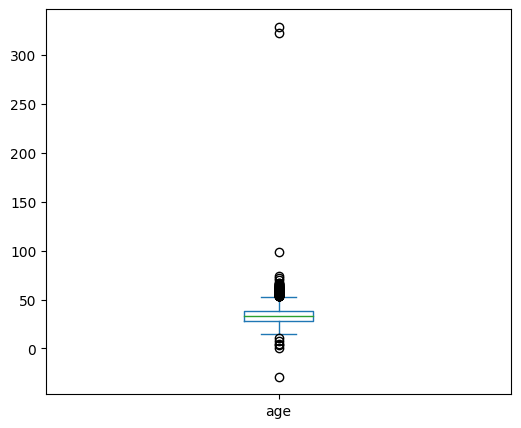

In [40]:
age_boxplot = survey_data.age.plot.box(figsize=(6, 5))

From this we can see that there are multiple values that seem to be outliers - two that seem to reach over 300 years and one that is below 0 years. Let's remove these outliers.

In [41]:
z_scores = np.abs((survey_data['age'] - survey_data['age'].mean()) / survey_data['age'].std())

threshold = 4

outliers = z_scores > threshold

outliers_data = survey_data[(outliers) | (survey_data.age < 0)]
outliers_data

Question,Survey_year,additional_notes,age,belief_coworkers_negatively_view_knowing_MHI,belief_discussing_mental_health_has_negative_consequences_in_curr_employer,belief_discussing_mental_health_has_negative_consequences_in_prev_employer,belief_discussing_physical_health_has_negative_consequences_in_curr_employer,belief_discussing_physical_health_has_negative_consequences_in_prev_employer,belief_having_MHI_would_hurt_career,believes_has_disorders,condition_interferes_w_work,coworker_reaction_mental_disorder,curr_coworker_discussed_mental_health_w_them,curr_employer_anonimity_protected_using_treatment,curr_employer_formally_discussed_mental_health,curr_employer_mental_health_importance,curr_employer_mental_physical_importance_balance,curr_employer_physical_health_importance,curr_employer_provides_help_resources,curr_employer_provides_help_resources,curr_employer_tech_organization,currently_has_mental_health_disorder,describe_bad_response,describe_convo_about_MH_actions_w_employer,describe_convo_about_MH_actions_w_prev_employer,describe_convo_about_MH_reactions_w_coworkers,describe_convo_about_MH_reactions_w_prev_coworkers,describe_convo_about_coworkers_MHI,describe_convo_about_coworkers_MHI,describe_good_response,describe_suggestions_to_improve_mental_health_for_employees_in_the_industry,discussed_mental_health_w_curr_coworkers,discussed_mental_health_w_curr_employers,discussed_mental_health_w_prev_coworkers,discussed_mental_health_w_prev_employers,easy_to_take_absence_because_of_illness,family_mental_health_history,feels_comfortable_discussing_mental_issues_w_curr_coworkers,feels_comfortable_discussing_mental_issues_w_curr_supervisor,feels_comfortable_discussing_mental_issues_w_prev_coworkers,feels_comfortable_discussing_mental_issues_w_prev_supervisor,gender,has_prev_employers,how_was_career_affected,identification_affected_career,industry_supports_employees_w_MHI_evaluation,insurance_on_MHD,knows_local_online_help_resources,knows_options_under_health_coverage,living_country,mental_disorder_in_past,nr_of_employees,observed_bad_response_to_MHI,observed_good_response_to_MHI,observed_negative_consequences_for_coworkers_MHI,observed_negative_consequences_of_MHI_in_curr_employer,observed_negative_consequences_of_MHI_in_prev_employer,openly_identified_mental_health_issue,others_confession_affected_own_MHI_reveal,perc_work_time_affected_by_MHI,preferred_health_topic_w_coworkers,preferred_health_topic_w_prev_employer,prev_coworker_discussed_mental_health_w_them,prev_employer_anonimity_protected_using_treatment,prev_employer_mental_health_importance,prev_employer_physical_health_importance,prev_employer_tech_organization,prev_employers_formally_discussed_mental_health,prev_employers_mental_physical_importance_balance,prev_employers_provided_help_resources,prev_employers_provided_help_resources,prev_employers_provided_help_resources,previously_diagnosed_w_mental_health_disorder,productivity_affected_by_MHI,race,reveal_disorder_to_coworkers,revealed_mental_health_to_clients_how_relationship_was_affected,revealed_mental_health_to_clients_was_negatively_impacted,revealed_mental_health_to_coworkers_how_relationship_was_affected,revealed_mental_health_to_coworkers_was_negatively_impacted,reveals_disorder_to_clients,role_tech,self_employed,sought_treatment_from_professional,treated_disorder_interferes_w_work_freq,untreated_disorder_interferes_w_work_freq,us_state,was_diagnosed_with,willing_to_discuss_mental_health_w_coworkers,willing_to_discuss_mental_health_w_supervisor,willing_to_provide_extensive_comments,willing_to_share_mental_illness_with_close_ones,willing_to_speak_mental_issue_job_interview,willing_to_speak_physical_issue_job_interview,work_position,work_us_state,working_country,works_remotely
UserID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
144,2014,NaN,-29.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [42]:
survey_data = survey_data[~survey_data.index.isin([*outliers_data.index])]

There also seems to be a person that works until they are 99 years old, which is highly unlikely. Thus we remove the users responses as well. One thing that caught my eye was that a lot of these columns have Null values in them. Let's check what is the percentage of all non-responses that we got for each question compared to how many people were shown the question altogether. Note that due to the high number of features, we remove all questions that had less than 50% of their respondents answer. This is to shorten the analysis whilst also keeping only the metrics that have the highest possibility of giving statistically significant relationships. 

In [43]:
grouped_nas = round(survey_data.isna().sum() / survey_data.Survey_year.count() * 100.0, 2)
relevant_features = grouped_nas[grouped_nas < 50].sort_values(ascending = False).index
survey_data = survey_data[relevant_features]
survey_data.dropna(how='all', inplace = True)
grouped_nas[grouped_nas < 50].sort_values(ascending = False)

Question
feels_comfortable_discussing_mental_issues_w_prev_supervisor                    43.09
belief_discussing_mental_health_has_negative_consequences_in_curr_employer      43.00
belief_discussing_physical_health_has_negative_consequences_in_curr_employer    43.00
prev_employers_formally_discussed_mental_health                                 42.67
feels_comfortable_discussing_mental_issues_w_curr_coworkers                     41.81
feels_comfortable_discussing_mental_issues_w_curr_supervisor                    41.81
us_state                                                                        38.49
works_remotely                                                                  36.19
easy_to_take_absence_because_of_illness                                         34.27
mental_disorder_in_past                                                         32.80
currently_has_mental_health_disorder                                            32.80
willing_to_share_mental_illness_with_close_on

In [44]:
survey_data = survey_data[relevant_features]

Most of the columns that we have not removed from the analysis are either key information that is (presumably) mandatory (e.g. age, gender, self_employed) and some mental health related questions that do not require the respondent to fit any sort of criteria (e.g. no `If yes, what condition(s) have you been diagnosed with?`). Having done the preporatory work for this analysis, we shall first analyze the distribution of the numeric metrics and ordinal categorical/boolean values we observe in the dataset.

In [45]:
features_to_measure = survey_data.select_dtypes(include = 'float64').columns.sort_values()

survey_data[features_to_measure].describe()

Question,age,belief_discussing_mental_health_has_negative_consequences_in_curr_employer,belief_discussing_physical_health_has_negative_consequences_in_curr_employer,curr_employer_formally_discussed_mental_health,curr_employer_tech_organization,currently_has_mental_health_disorder,easy_to_take_absence_because_of_illness,family_mental_health_history,feels_comfortable_discussing_mental_issues_w_curr_coworkers,feels_comfortable_discussing_mental_issues_w_curr_supervisor,feels_comfortable_discussing_mental_issues_w_prev_supervisor,has_prev_employers,knows_options_under_health_coverage,mental_disorder_in_past,prev_employers_formally_discussed_mental_health,self_employed,sought_treatment_from_professional,willing_to_share_mental_illness_with_close_ones,willing_to_speak_mental_issue_job_interview,willing_to_speak_physical_issue_job_interview,works_remotely
count,4209.000000,2402.000000,2402.000000,3295.000000,3710.000000,2832.000000,2770.000000,3565.000000,2452.000000,2452.000000,2398.000000,2956.000000,3133.000000,2832.000000,2416.000000,4196.000000,4214.000000,2844.000000,4214.000000,4214.000000,2689.000000
mean,33.817534,0.414446,0.155079,0.251290,0.777628,0.547316,2.649819,0.523422,0.492251,0.545677,0.351960,0.875507,0.474944,0.591984,0.142591,0.154909,0.571903,2.718706,0.177504,0.429639,0.674972
std,8.128131,0.377506,0.273411,0.433821,0.415896,0.438624,1.506735,0.499521,0.377808,0.406186,0.303261,0.330198,0.470484,0.442285,0.253854,0.361861,0.494862,1.372429,0.290986,0.370041,0.688966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,33.000000,0.500000,0.000000,0.000000,1.000000,0.500000,2.000000,1.000000,0.500000,0.500000,0.500000,1.000000,0.500000,0.750000,0.000000,0.000000,1.000000,3.000000,0.000000,0.500000,1.000000
75%,38.000000,0.500000,0.500000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,0.500000,0.000000,1.000000,4.000000,0.500000,0.500000,1.000000
max,74.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000


In [46]:
IQRs = survey_data[features_to_measure].quantile(0.75) - survey_data[features_to_measure].quantile(0.25)
IQRs

Question
age                                                                             10.0
belief_discussing_mental_health_has_negative_consequences_in_curr_employer       0.5
belief_discussing_physical_health_has_negative_consequences_in_curr_employer     0.5
curr_employer_formally_discussed_mental_health                                   1.0
curr_employer_tech_organization                                                  0.0
currently_has_mental_health_disorder                                             1.0
easy_to_take_absence_because_of_illness                                          3.0
family_mental_health_history                                                     1.0
feels_comfortable_discussing_mental_issues_w_curr_coworkers                      1.0
feels_comfortable_discussing_mental_issues_w_curr_supervisor                     1.0
feels_comfortable_discussing_mental_issues_w_prev_supervisor                     0.5
has_prev_employers                                      

What we can see here is that the in total there were `4209 participants` in the study entirely with the average age of a participant being `33.8 years`. The standard deviation of the age value is around 8.1 years, which means that there is quite a wide range of values that we see in the age bracket, that is also shown via the `IQR`, which is `10 years`, meaning that there is a 10 year difference between the 0.25 quartile and the 0.75 quartile.

In terms of the other metrics, we can roughly say that based on the mean of the responses:
* Respondents believe that they would prefer not to talk about their mental health in their current employer as they believe that there would be negative consequences (the average is around `0.4144`)
* But they would much less prefer talking about their `physical health` as the average is only `0.155`.
* Current employers that our respondents worked for had more than not formally talked about mental health through official channels (mean: `0.7776`). This is actually way better than what respondents were getting in their previous employers as the average in their previous employers was `0.142591`. Meaning current employers are much more likely to talk about mental health disorders formally than previous employers. 
* Mostly people are on the fence on whether they have mental health disorders as the average value for the `currently_has_mental_health_disorder` metric is `0.5473` and the standard deviation is aroudnd `0.439`- almost an entire half swing. 
* It is neutral in terms of easiness to take absence due to mental health for our respondents, but the metric also has a standard deviation of 1.5 categories, which makes it quite variable. 
* Same for the `family_mental_health_history` boolean, either half of the people struggle with one, or the respondents are mostly unsure about their family history with mental health disorders
* Quite surprisingly, people are more comfortable with talking about mental health with their current employers, rather than their current coworkers (supervisor mean = `0.545677`, coworker mean = `0.492251`).
* Speaking on the same topic, respondents also feel way more comfortable (on average) to talk to `current supervisors` about mental health issues, compared to `previous supervisors`. This indicates a positive trend of people finding better employers over time.
* More people than not have had a mental disorder in the past (although the metric still displays quite high variance). 
* Very few people were willing to share mental health issues during a potential employers job interview (mean is around `0.177504`). But much more willing to share about a physical issue (mean = `0.429639`)
* Very few people are self-employed (mean = `0.154909`) and more people than not work remotely (mean = `0.67498`)

The median of 'age' (green line) is slightly to the left of the mean (red line). This is due to the distribution being skewed to the right


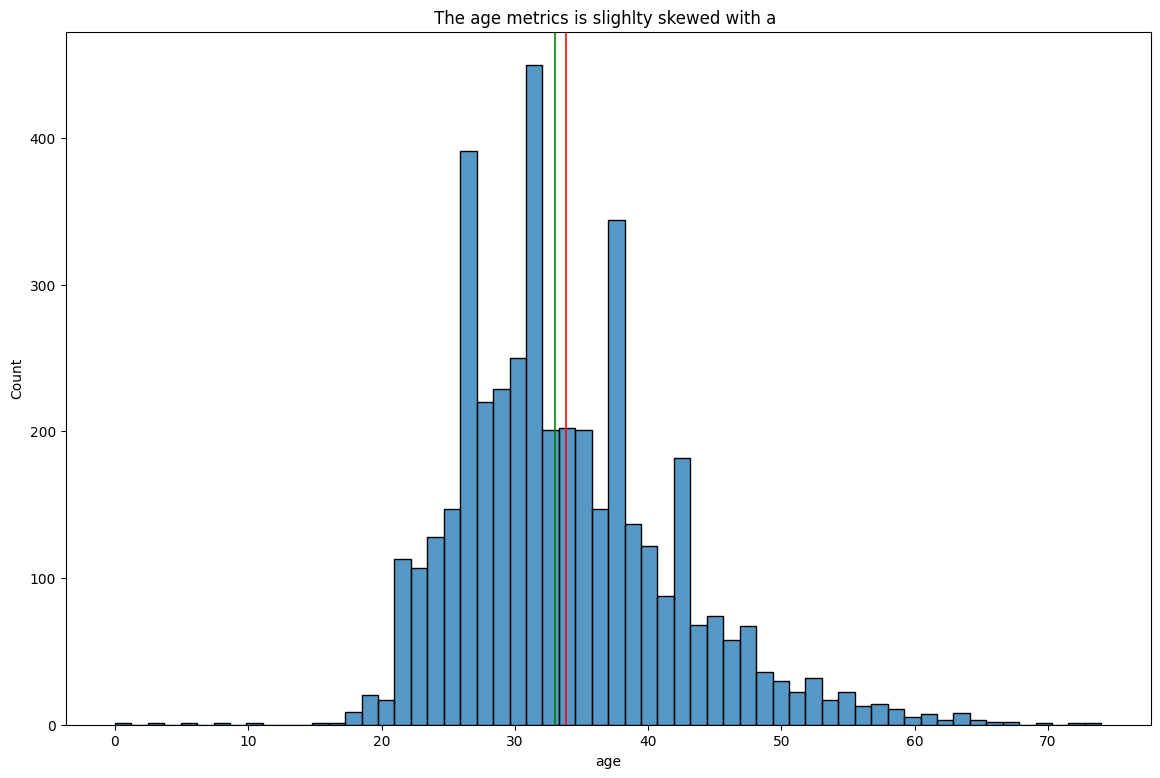

In [47]:
fig = plt.figure(figsize=(14, 9))
sns.histplot(data=survey_data, x="age")
plt.axvline(x = survey_data.age.mean(), color = 'red', linestyle = '-', alpha = 0.8)
plt.axvline(x = survey_data.age.median(), color = 'green', linestyle = '-', alpha = 0.8)
plt.title("The age metrics is slighlty skewed with a ")
print("The median of 'age' (green line) is slightly to the left of the mean (red line). This is due to the distribution being skewed to the right")

What if we looked into where the responses came from? Since previously we have already seen that most people that responded to the surveys work in the United States, I assume living countries should portray the same trend.

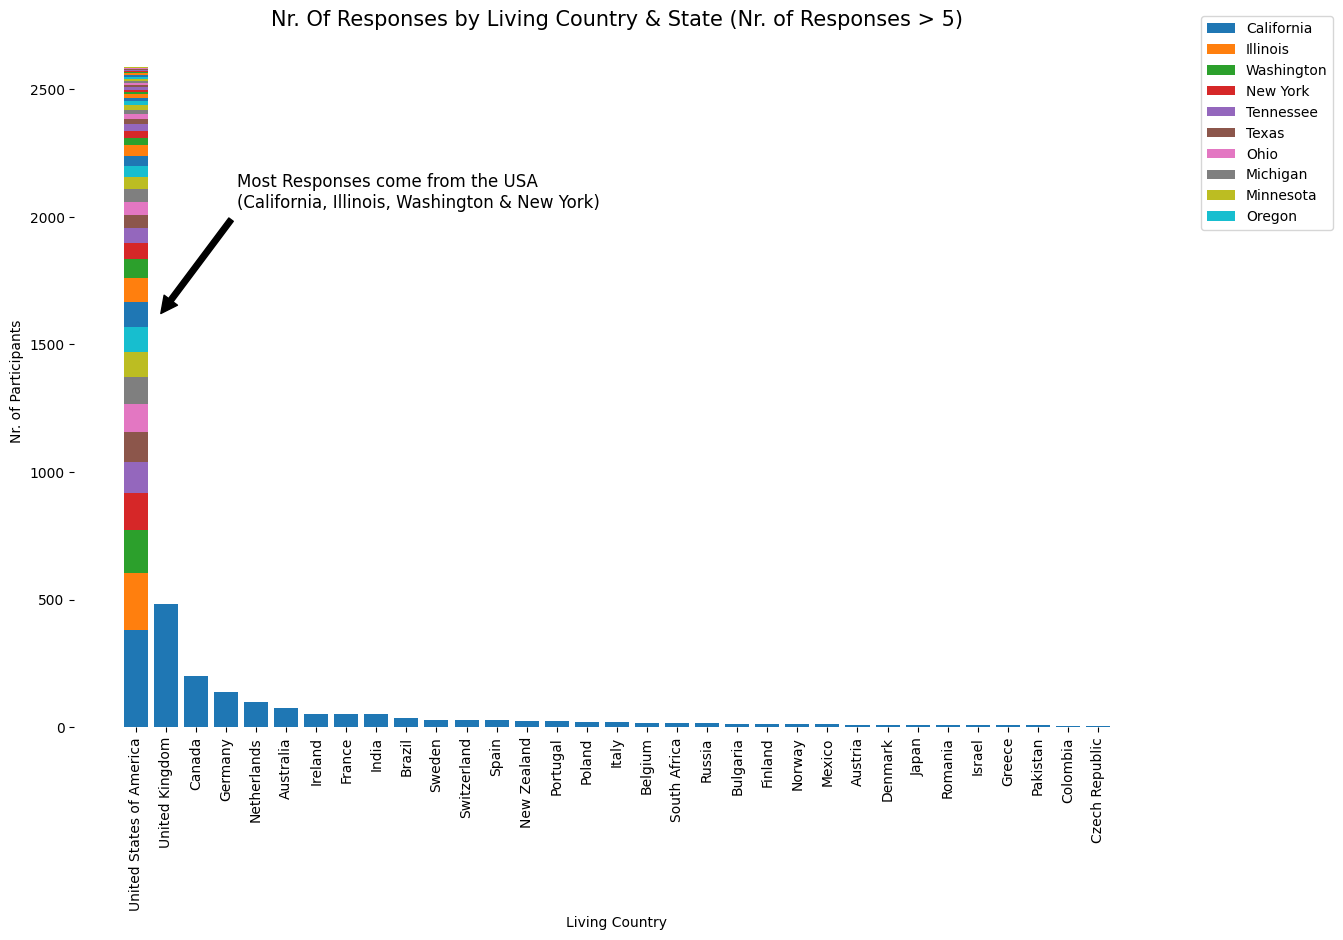

In [48]:
fig = plt.figure(figsize=(14, 9))

df_us = survey_data[survey_data.living_country == 'United States of America'].groupby('us_state').age.count()

df_non_us = survey_data[survey_data.living_country != 'United States of America'].groupby('living_country').age.count().sort_values(ascending=False)

df_non_us = df_non_us[df_non_us.values > 5]

height = 0
labels, bars = [], []
for i, state in enumerate(df_us.sort_values(ascending=False).index):
    df_state = df_us[df_us.index == state]
    bar_us = plt.bar('United States of America', df_state.values, bottom = height, label = state)
    height += df_state.values
    if i < 10:
        labels.append(state)
        bars.append(bar_us)

plt.xticks(rotation=90)

bar = plt.bar(df_non_us.index, df_non_us.values)

remove_borders()

plt.xticks(rotation=90)
plt.xlabel('Living Country')
plt.ylabel('Nr. of Participants')


fig.legend(bars, labels, bbox_to_anchor=(0.93, 0.9),
          loc='upper left', borderaxespad=0, fontsize = 10);

plt.title('Nr. Of Responses by Living Country & State (Nr. of Responses > 5)', fontsize = 15)


plt.annotate(
    text="Most Responses come from the USA\n(California, Illinois, Washington & New York)",
    xy=(0.7, 1600), 
            xytext=(0.15, 0.8), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(facecolor='black', shrink=0.05),
    size = 12)
fig.show()

No surprise, the most popular country is the `United States of America`, followed by `United Kingdom`, `Canada`, `Germany` & `The Netherlands` as the top 5. As for the United States, most particiapnts live in `California`, `Illinois`, `Washington`, `New York`, which all represent the biggest tech hubs within the country (`Calfornia` - Silicon Valley, `Washington` - Seattle, `New York` - Manhattan). Interestingly, most of the responses come from either North America or Europe. In fact, only 9 other countries from other continents are represented in the table above. This might be due to the fact that those companies in other continents are harder to reach (meaning that a convenience sample was being used) or that there are simply not many such companies on the other continents.

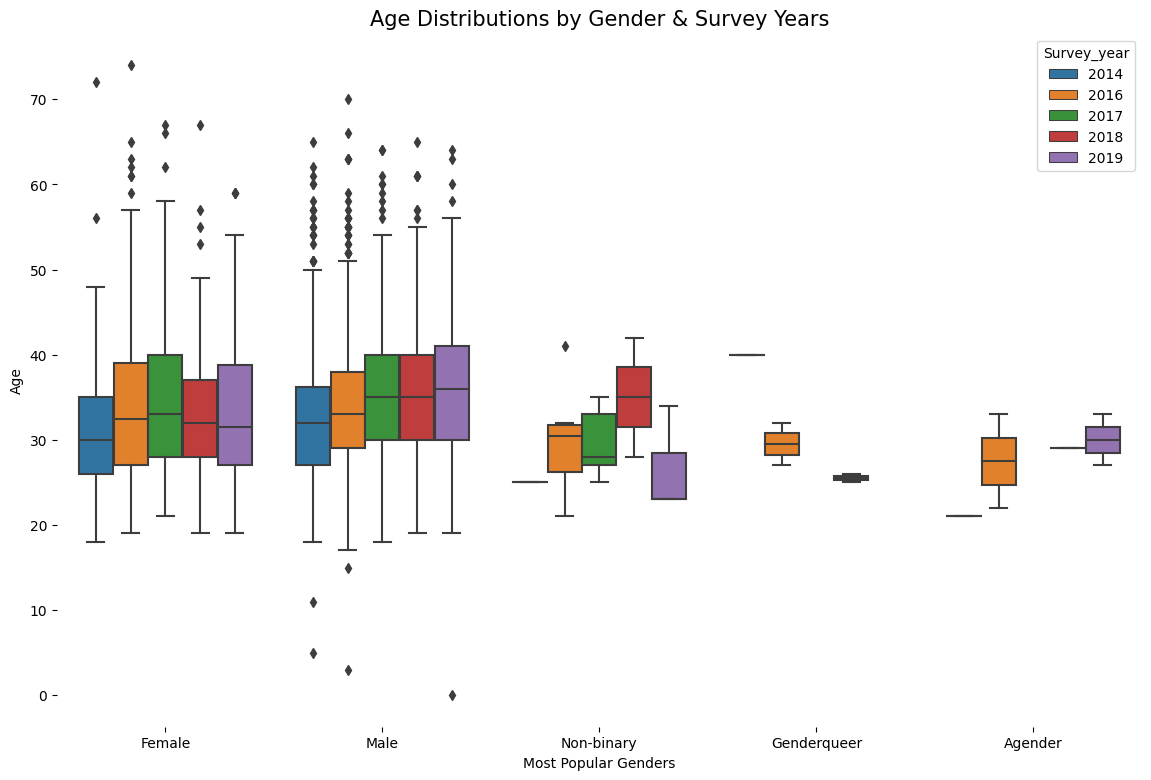

In [49]:
fig = plt.figure(figsize=(14, 9))

largest_genders = survey_data['gender'].value_counts().nlargest(5)
sns.boxplot(x='gender', y='age', hue="Survey_year", data=survey_data[survey_data['gender'].isin(largest_genders.index)][['gender', 'Survey_year', 'age']])

remove_borders()
plt.xlabel('Most Popular Genders')
plt.ylabel('Age')

plt.title('Age Distributions by Gender & Survey Years', fontsize = 15)
fig.show()

From this we can see that specifically the average age has seen quite significant change over the years of the Survey being run. Specifically for females, we can see that the average age stays around 32 years and reaches a peak during the 2017 Survey. As for men, the average age seems to be steadily increasing each year (perhaps reflecting the aging male workforce?). This is actually also seen at the top of each box for the `males` - there are quite a lot more black dots representing older outliers. Quite interesting for the`male` side of the respondents is that there are several kids that seem to be working as well. The variance over the years seems to increase for both main genders, but the degree in which the standard deviation fluctuates is higher for `women` than for `men`.

As for the other genders, there seems to be not enough data each year to actually provided meaningful insights, but at least for `Non-binary` people the age seems to represent a quite big range and varies year to year. That is actually quite surprising, because I didn't know the Non-binary community can be so diverse.

What if we looked at the same metric but split it by whether people currently have a mental health disorder?

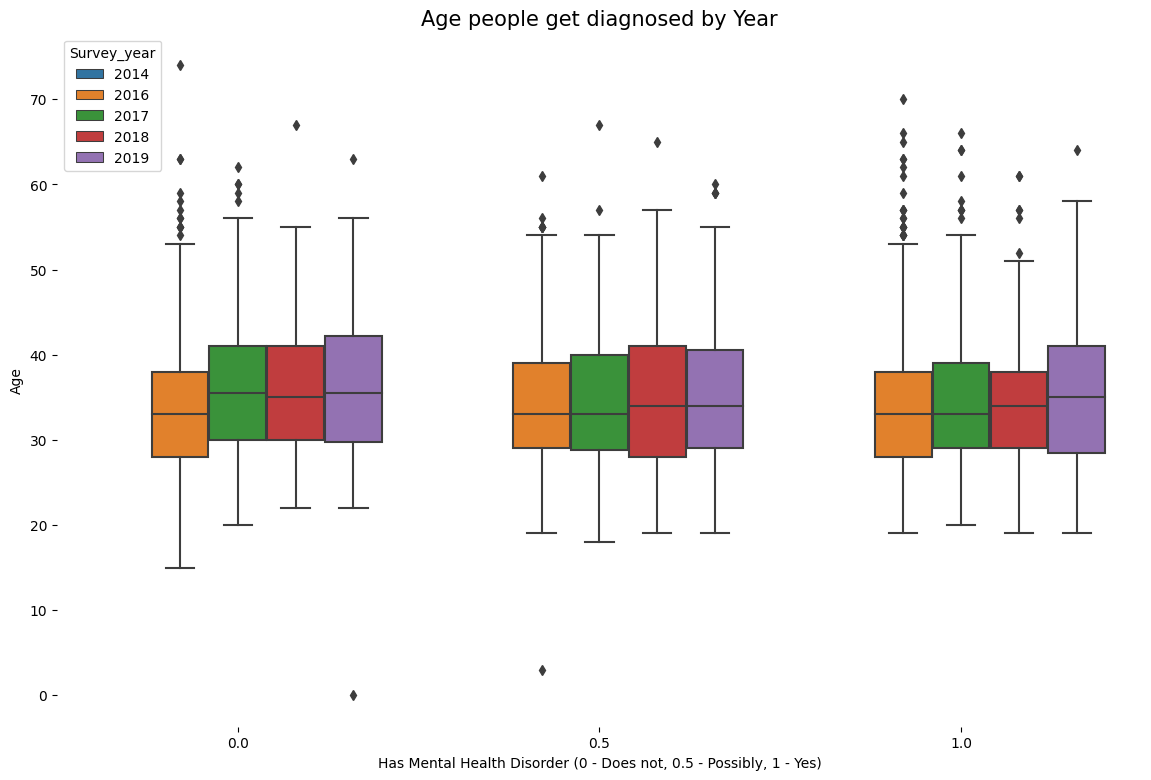

In [50]:
fig = plt.figure(figsize=(14, 9))

largest_genders = survey_data['gender'].value_counts().nlargest(5)
sns.boxplot(x='currently_has_mental_health_disorder', y='age', hue="Survey_year", data=survey_data)
remove_borders()
plt.xlabel('Has Mental Health Disorder (0 - Does not, 0.5 - Possibly, 1 - Yes)')
plt.ylabel('Age')

plt.title('Age people get diagnosed by Year', fontsize = 15)
fig.show()

Here we can confidently see that the distributions between whether people had or did not have any mental health disorders is not dependent on `age`. This dependency also seems to be stagnant. Although there seems to be at least a bit more older outliers in the section of mental health disorder having participants.

What if we looked at the age distribution by easiness to take an absence due to illness. The logic is that maybe through `age` being a good proxy for experience/seniority in a workplace, their companies would be less inclined to let the person go on vacation. And that would be especially pronounced for smaller companies that do not have many people to cover work.

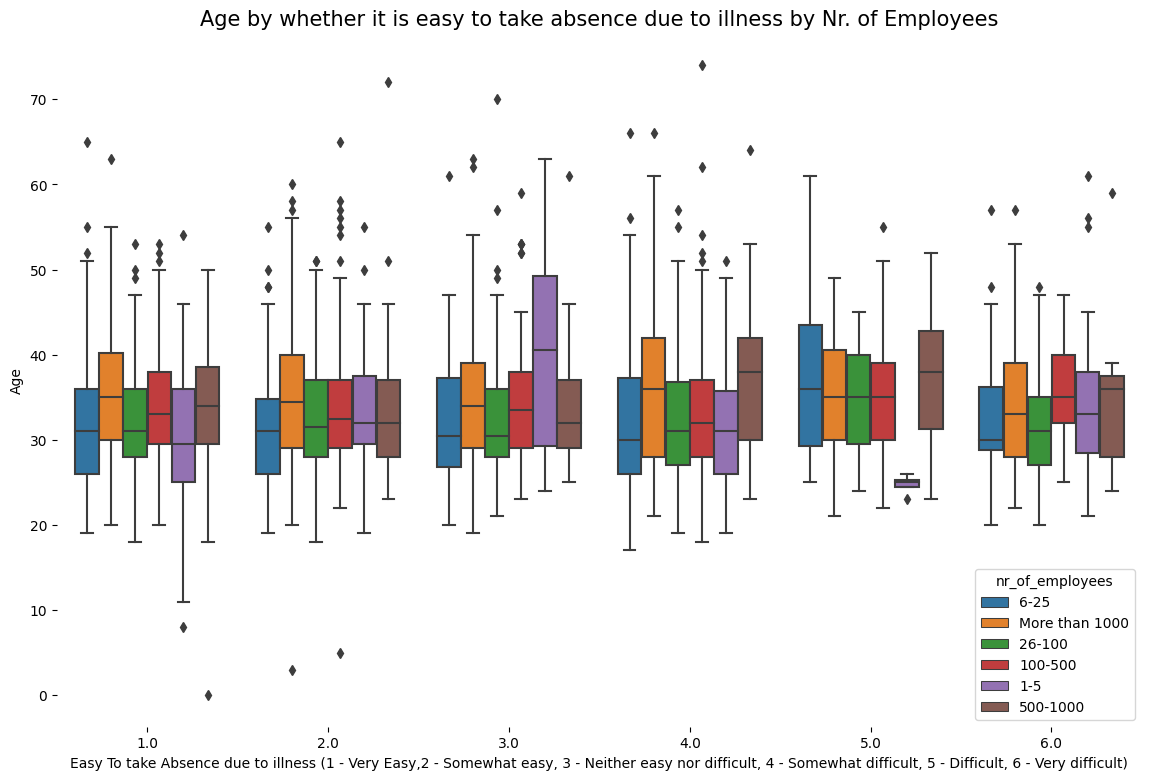

In [51]:
fig = plt.figure(figsize=(14, 9))

largest_genders = survey_data['gender'].value_counts().nlargest(5)
sns.boxplot(x='easy_to_take_absence_because_of_illness', y='age', hue="nr_of_employees", data=survey_data)
remove_borders()
plt.xlabel('Easy To take Absence due to illness (1 - Very Easy,2 - Somewhat easy, 3 - Neither easy nor difficult, 4 - Somewhat difficult, 5 - Difficult, 6 - Very difficult)')
plt.ylabel('Age')

plt.title('Age by whether it is easy to take absence due to illness by Nr. of Employees', fontsize = 15)
fig.show()

There seems to be no such pattern, but there are some other interesting findings:
* For companies of size `1-5`, it is Difficult to take absence for younger employees, but easier for older people.
* The `1-5` company size results are in general very variable, which most likely describes how each small company can have very different situations.

Alright, this was not the most helpful, let's look into whether the tech industry is actually attracting more people with mental health issues, or are they creating the mental health issues themselves (the question I raised previously):

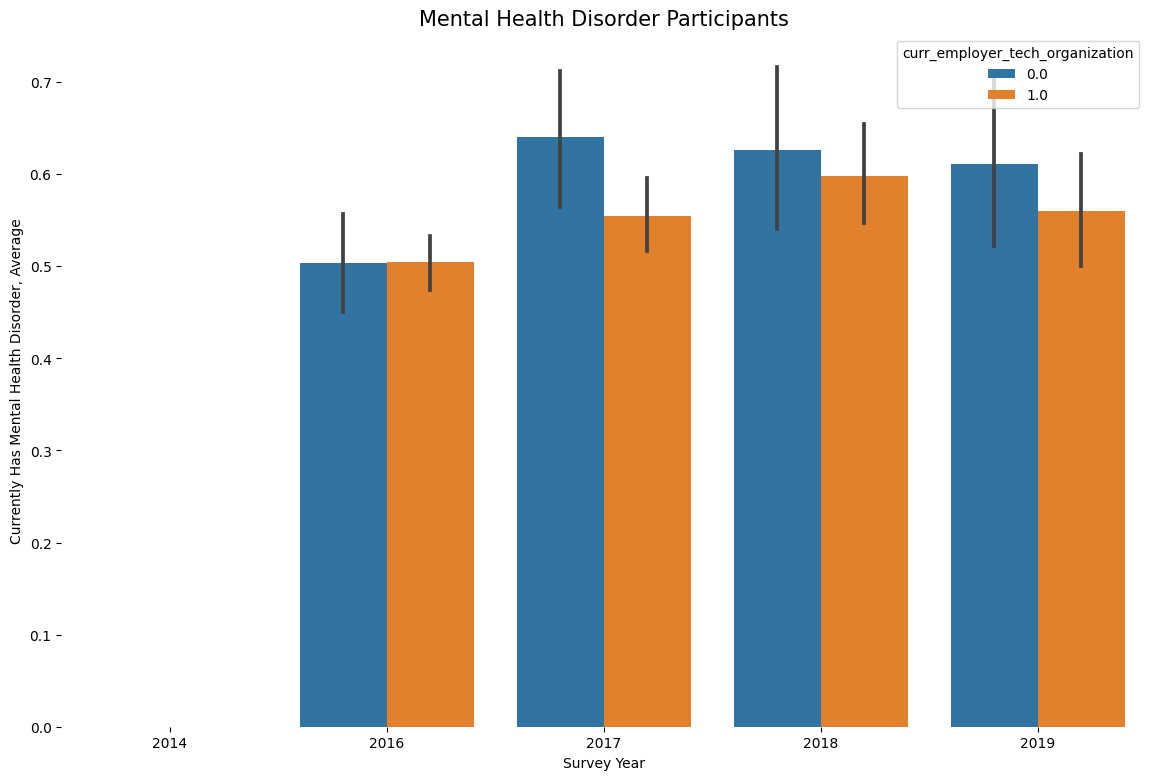

In [52]:
fig = plt.figure(figsize=(14, 9))

sns.barplot(x='Survey_year', y='currently_has_mental_health_disorder', hue="curr_employer_tech_organization", data=survey_data)
remove_borders()
plt.xlabel('Survey Year')
plt.ylabel('Currently Has Mental Health Disorder, Average')

plt.title('Mental Health Disorder Participants', fontsize = 15)
fig.show()

This is actually very interesting - It seems as though over the years, the tech organizations have lower amounts of people reported to be suffering from mental illness. Although the difference between them and non-tech organizations is not big by any means, it is still quite surprising given the fact that the industry is quite challenging. 

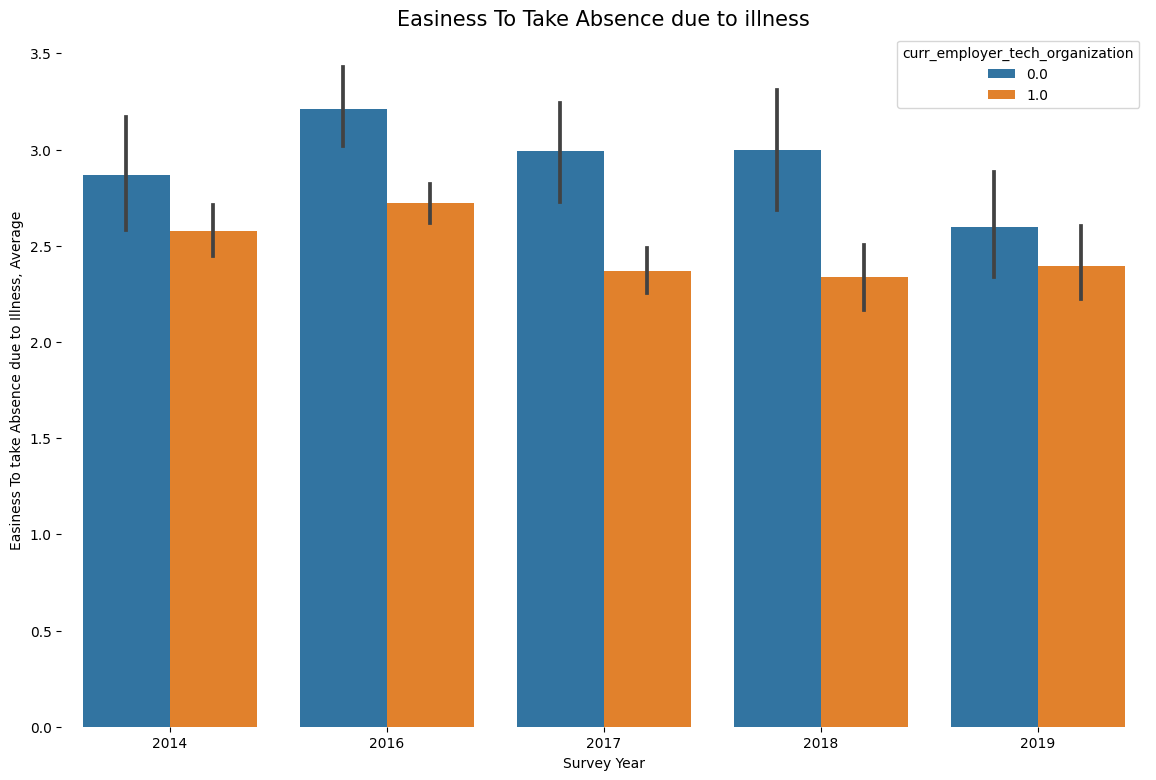

In [53]:
fig = plt.figure(figsize=(14, 9))

sns.barplot(x='Survey_year', y='easy_to_take_absence_because_of_illness', hue="curr_employer_tech_organization", data=survey_data)
remove_borders()
plt.xlabel('Survey Year')
plt.ylabel('Easiness To take Absence due to Illness, Average')

plt.title('Easiness To Take Absence due to illness', fontsize = 15)
fig.show()

Tech organizations seem to have easier access to absence due to illness, which actually contradicts what I hypothesized previously. The good news is that it seems that access to mental health disorder leave has been increasing YoY ever since 2016. Although, since the metric has not lowered that much, it might just be normal yearly variation between slightly different samples. What about seeking help from a professional?

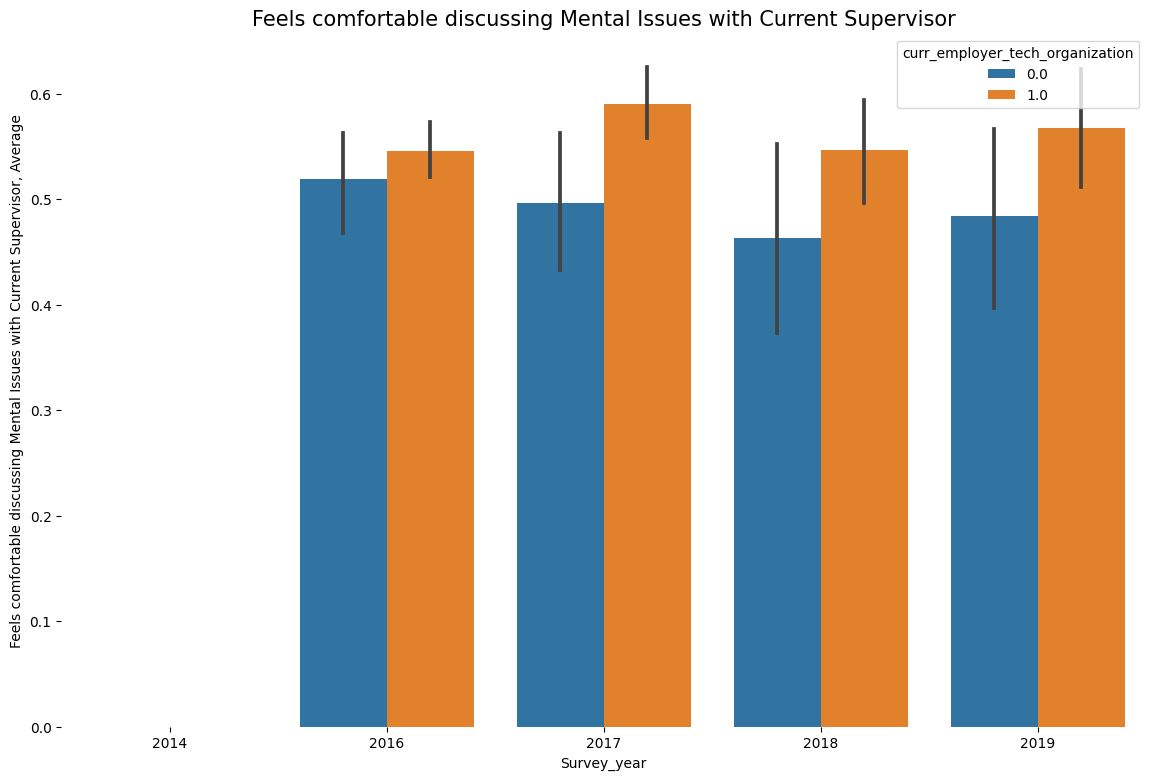

In [54]:
fig = plt.figure(figsize=(14, 9))

sns.barplot(x='Survey_year', y='feels_comfortable_discussing_mental_issues_w_curr_supervisor', hue="curr_employer_tech_organization", data=survey_data)
remove_borders()
plt.xlabel('Survey_year')
plt.ylabel('Feels comfortable discussing Mental Issues with Current Supervisor, Average')

plt.title('Feels comfortable discussing Mental Issues with Current Supervisor', fontsize = 15)
fig.show()

And again, tech organizations seem to be coming on top in this section as well, since each year tech organizations are workplaces where people feel more comfortable discussing their mental woes with their supervisors, compared to non tech organizations. Interestingly, this question was not in the survey in 2014. The gap between tech organizations and non-tech organizations also seems to be widening over the years, which could either mean the tech organizations inovating more in the mental health sphere of their employees. 

Can we compare this with their previous employers?

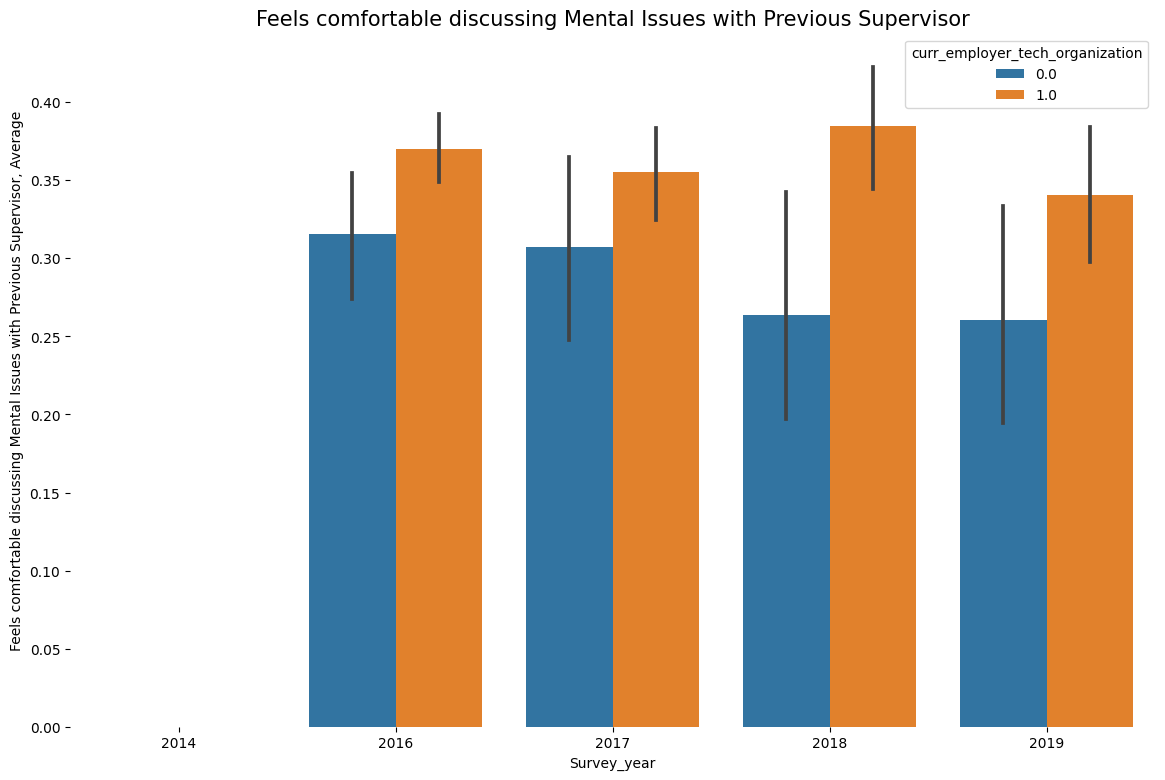

In [55]:
fig = plt.figure(figsize=(14, 9))

sns.barplot(x='Survey_year', y='feels_comfortable_discussing_mental_issues_w_prev_supervisor', hue="curr_employer_tech_organization", data=survey_data)
remove_borders()
plt.xlabel('Survey_year')
plt.ylabel('Feels comfortable discussing Mental Issues with Previous Supervisor, Average')

plt.title('Feels comfortable discussing Mental Issues with Previous Supervisor', fontsize = 15)
fig.show()

Yes, even here we can see the same trend, however, the absolute values between the years seem to be lower than for current supervisors, meaning that people are generally more satisfied with their current workplaces than previously. What about being willing to speak on your mental health issues during and interview?

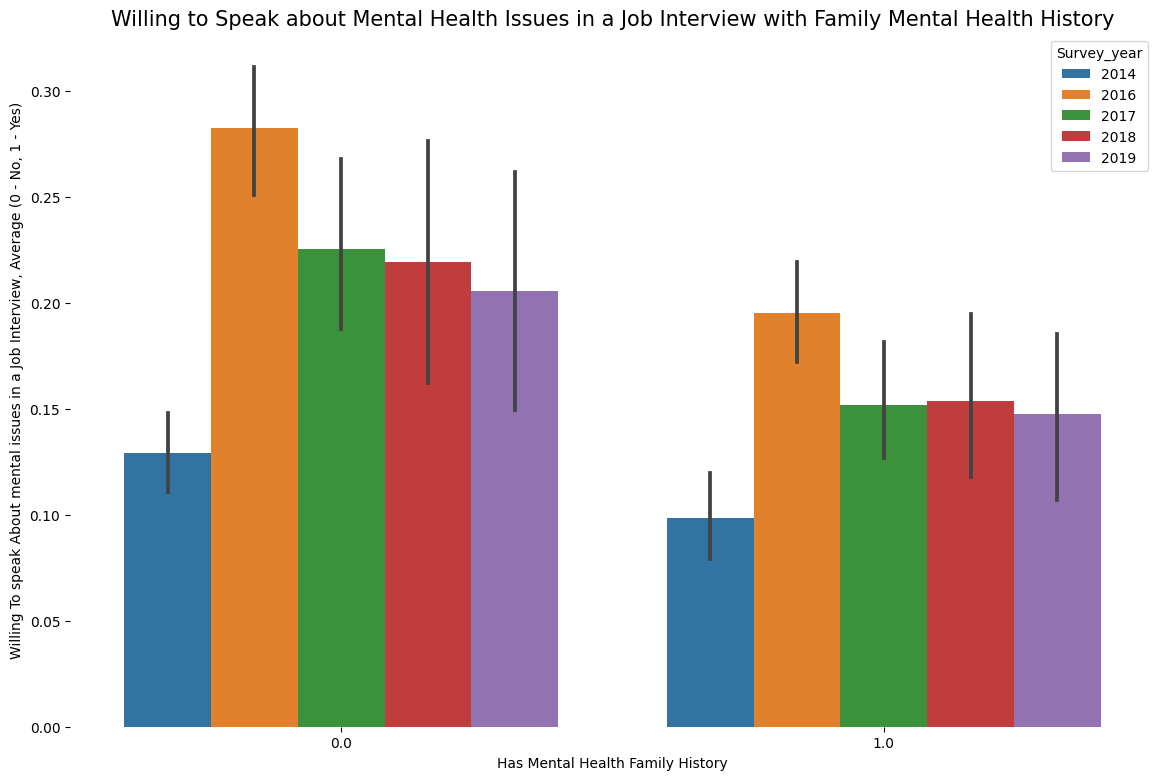

In [56]:
fig = plt.figure(figsize=(14, 9))
remove_borders()
sns.barplot(x='family_mental_health_history', y='willing_to_speak_mental_issue_job_interview', hue="Survey_year", data=survey_data)

plt.xlabel('Has Mental Health Family History')
plt.ylabel('Willing To speak About mental issues in a Job Interview, Average (0 - No, 1 - Yes)')

plt.title('Willing to Speak about Mental Health Issues in a Job Interview with Family Mental Health History', fontsize = 15)
fig.show()

This is actually somewhat expected, because if a person's family has history with mental health issues, you could expect that they themselves see that as a sad thing to talk about. Which is why they would not bring it up, especially on an interview. Generally, we should note that the values seem to be low (max is even lower than 0.3). But the development over the years the survey was taken is actually pretty variable, with relatively low values in the year 2014, but then very high values in the year 2016. The trend also seems to be going down over the last three years, which makes me think that people are getting less interested in talking about mental health issues during job interviews. This is actually quite surprising, because with the whole world opening up to mental health more and more, I would think that people would be more incentivised to speak up about these things. 

What about whether the participants are able to speak up about their mental health split up by Company size?

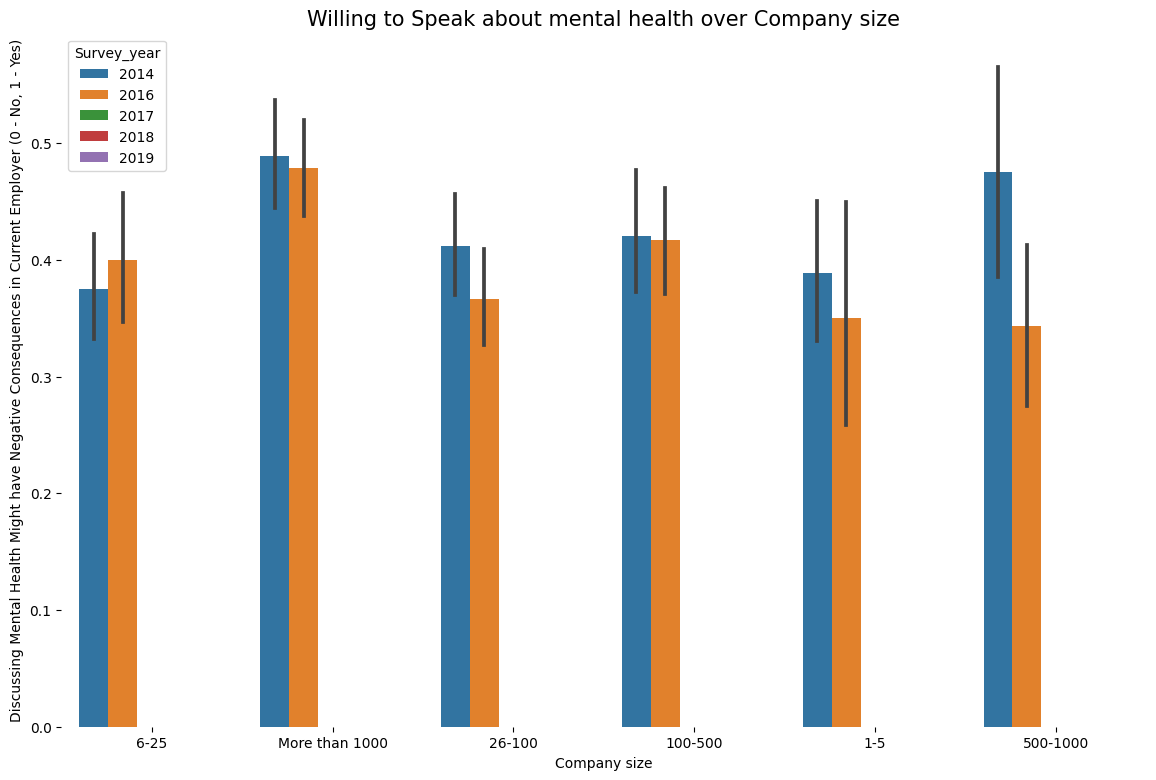

In [57]:
fig = plt.figure(figsize=(14, 9))

sns.barplot(x='nr_of_employees', y='belief_discussing_mental_health_has_negative_consequences_in_curr_employer', hue="Survey_year", data=survey_data)
remove_borders()
plt.xlabel('Company size')
plt.ylabel('Discussing Mental Health Might have Negative Consequences in Current Employer (0 - No, 1 - Yes)')

plt.title('Willing to Speak about mental health over Company size', fontsize = 15)
fig.show()

This is actually quite telling - the biggest divide between years for whether people feel that discussing mental health with their employers has a negative effect happened for `500-1000 employee-sized` companies, which means that over the years 2014-2016, these companies were able to improve their standing with their employees a lot more than smaller companies, because e.g. `6-25` employee companies actually slightly performed worse - meaning that their employees were actually more scared of talking about their mental health compared to previously. This trend is only visible for this subgroup of companies, though. It would have been very interesting if the same question would have been present in the latest three surveys, but that however, was not the case. 

What about talking mental health with their current coworkers v supervisors?

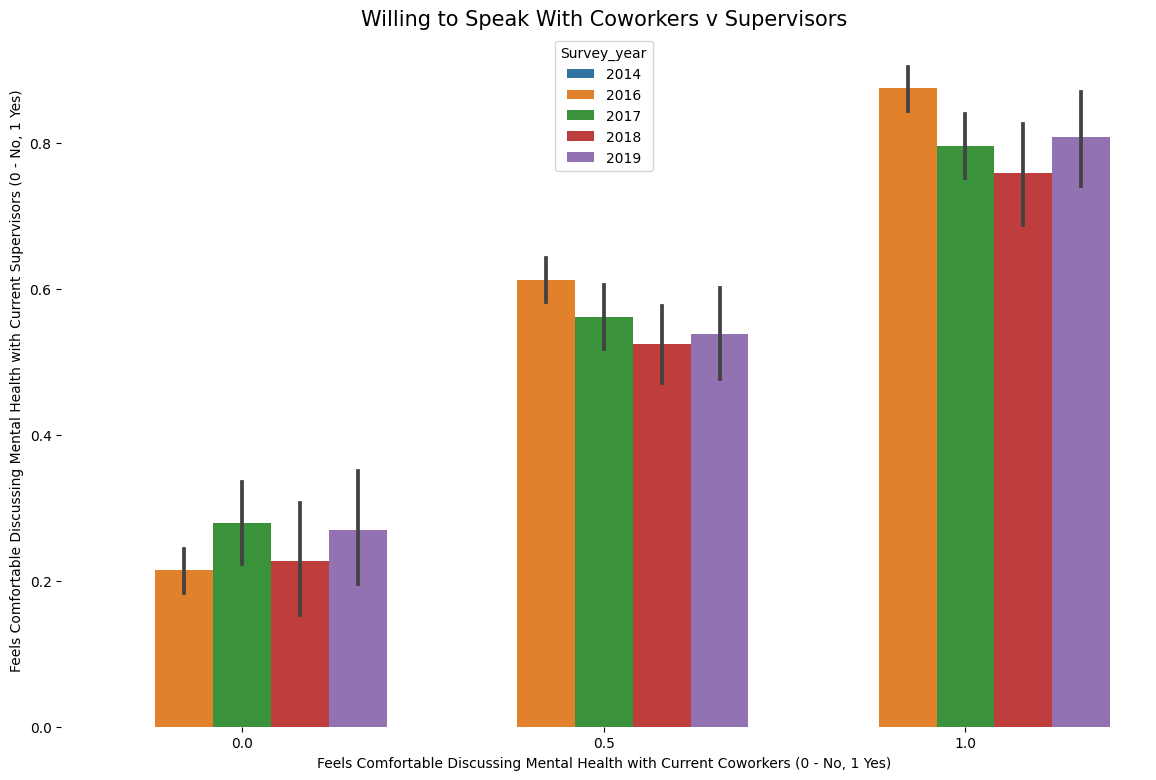

In [58]:
fig = plt.figure(figsize=(14, 9))

sns.barplot(x='feels_comfortable_discussing_mental_issues_w_curr_coworkers', y='feels_comfortable_discussing_mental_issues_w_curr_supervisor', hue="Survey_year", data=survey_data)
remove_borders()
plt.xlabel('Feels Comfortable Discussing Mental Health with Current Coworkers (0 - No, 1 Yes)')
plt.ylabel('Feels Comfortable Discussing Mental Health with Current Supervisors (0 - No, 1 Yes)')

plt.title('Willing to Speak With Coworkers v Supervisors', fontsize = 15)
fig.show()

The relationship here is actually quite simple to interpret - the more a person is scared of talking to a coworker about mental health, they will most likely be scared the same way for Supervisors as well. Over the years, the uncomfortableness to talk about mental health has actually decreased (but not by much), when it saw a bump up again in 2019. As for people that Don't feel comfortable talking with either of the two, their values for comfortability of talking with coworkers seems to be stagnant with some little variance around a mean of `~0.2`.

Lastly, let's look at whether people were more willing to speak about mental or physical issues during a job interview?

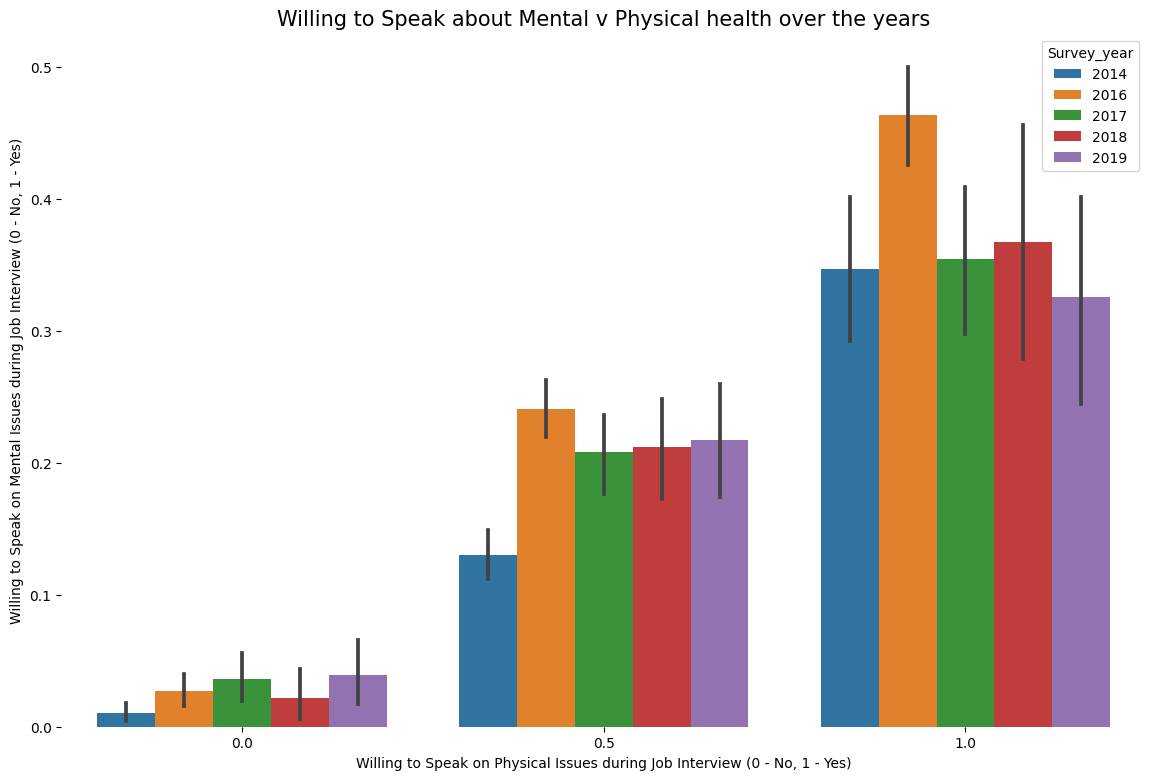

In [59]:
fig = plt.figure(figsize=(14, 9))

sns.barplot(x='willing_to_speak_physical_issue_job_interview', y='willing_to_speak_mental_issue_job_interview', hue="Survey_year", data=survey_data)
remove_borders()
plt.xlabel('Willing to Speak on Physical Issues during Job Interview (0 - No, 1 - Yes)')
plt.ylabel('Willing to Speak on Mental Issues during Job Interview (0 - No, 1 - Yes)')

plt.title('Willing to Speak about Mental v Physical health over the years', fontsize = 15)
fig.show()

Again, we seem to be observing the same trends, except this team with more magnitude - the more the person is unlikely to speak about a physical issue during a job interview, the less likely the person will mention anything about Mental issues, since they are harder to open up about. And again, we see the same interesting dynamic where the results for 2014 are low just for them to jump in 2016 and come back to normal by 2017. This might be due to their beinga year missing from the data of the survey, but this bump is more visible the more likely the person is to speak on a physical issue during a job interview. 

## Conclusions

In conclusion, we have looked at the responses to a mental health survey in the tech industry over 4 years from 2014-2019 (skipping 2015). We have found that:

* The number of participants have been steadily decreasing, although the number of total questions asked has shot up.
* Percentage-wise, `~30%` of all questions are not responded to each year (again, except for `2014`).
* Most popular organizations have actually more than `1000 employees`, then we have it being followed by `26-100`, `100-500`, `6-25`, `1-5` & `500-1000`.
* Most respondents live in the `United States`, the `United Kingdom` or `Canada`. In terms of `US states`, there was a quite wide geographic distribution range for respondents, however most responses came from `California`, `Washington`, `New York` & `Illinois`. The other biggest continent in terms of responses was `Europe`, with `Germany` & the `Netherlands` leading the way.
* Around `68.5%` of companies that our respondents work in, work in tech orgnanizations, whereas ~20% seem to be working not for a tech organization. 
* `White` participants in terms of race seem to be dominating all responses, with all other races combined only have approximately `7.5%` of all responses made to the surveys in total.
* `42%` of all employees reported having mental health disorders throughout the 4 years of survey analysis. `~22% `of all respondents report that they possibly/maybe have a Mental Health Disorder.
* The survey conducted in 2014 generated the most amount of participation as a sizeable amount of all participants answered all questions to the survey. Later years were not as successful, with the next biggest fulfillment rate for a survey peaking `88.2%`. The top respondents in terms of fulfillment rate were: `4068`, `4071`, `3711`, `3414` & `2786`. However, their surveys, compared to the surveys made in 2014, had many more questions (2017, 2018, 2019 all had 76 questions, whereas 2014 only had 26).
* Respondents believe that they would prefer not to talk about their mental health in their current employer as they believe that there would be negative consequences. But they would much less prefer talking about their `physical health` as the average is only `0.155`.
* Current employers that our respondents worked for had more than not formally talked about mental health through official channels. This is actually way better than what respondents were getting in their previous employers. Meaning current employers are much more likely to talk about mental health disorders formally than previous employers.
* People are more comfortable with talking about mental health with their `current employers`, rather than their `current coworkers`. Respondents also feel more comfortable (on average) to talk to `current supervisors` about mental health issues, compared to `previous supervisors`. This indicates a positive trend of people finding better employers over time.
* Very few people were willing to share mental health issues during a potential employers job interview. But much more willing to share about a physical issue.
* Distributions between whether people had or did not have any mental health disorders is not dependent on `age`, which means that `age` is not really a factor in whether people suffer from mental health disorders.
* `Tech organizations` have lower amounts of people reported to be `suffering from mental illness`, compared to their non-tech counterparts. Tech organizations are where people feel more comfortable discussing their mental woes with their supervisors, compared to their non-tech counterparts as well. 
* People with `mental health disorder histories` in their families seem to be less likely to talk about mental health issues during interviews by around `10%`.
* There is somewhat a direct positive correlation between people feeling comfortable talking with about their `physical health` with their `supervisors` and talking about mental health with their `supervisors` - the more willing you are to talk about one, the more likely you will talk about the other. The same trend can be seen for `mental v physical health discussions` in job interviews, as well.


## Improvement Points

* While this is quite extensive analysis already, I would look into perhaps inferring some of the Null values based on features that we currently have in the dataset. This is because there is a lot of people that have only partially filled out the survey. So, if we were to be able to fill the dataset more, than we could be able to extract more accurate & powerful insights.
* I would also like to try modelling on, where perhaps using the features that are present in the table as independent variables and the percentage of questions filled in, I could be able to predict what type of people would fill out the survey or not. I could try and use a simple regression with a set of dummy variables to achieve that. 
* I would also like to the questions to be standardized going forward (which can kind of be seen ever since 2017). For continuity's sake, this would highly elevate the potential for Year over Year comparisons.
* Lastly, I would want to include a bit more information on the respondents themselves, such as:
    * `Seniority` - perhaps people with a higher seniority level have much more problems with mental health compared to lower level employees.
    * `Nr of previous employers` - perhaps if the person seems to be changing employers all the time - that might be the concern for why his mental health is taking a toll.
    * `Performance level (as evaluated by their supervisors)` - it would be interesting to see whether the people with mental health disorders actually perform worse, than ones that do not have a disease.
    * `Time in the company` - while this variable might have high correlation with the `Seniority` level, we could check for whether people in general are sick of their current employers because of being too long at the company. 